In this notebook, I will attempt to use RNN models, such as SimpleRNN, LSTM and GRU, to predict the next day's closing price of NASDAQ stocks. First, I will try to predict the actual closing price.

Let's start by introducing the functions.

## Function Descriptions

<div style="background-color: #fafafa; padding: 20px; border: 2px solid #d3d3d3; border-radius: 8px;">

### <span style="color: #696969; font-size: 20px;">create_dataset</span>
Creates a time-series dataset by windowing the data.

#### Parameters:
- X: Feature data
- y: Target data
- look_back (int): The window size for creating the dataset. Default is 1.

#### Returns:
- X_data: Windowed feature data
- y_data: Windowed target data

</div>

<div style="background-color: #fafafa; padding: 20px; border: 2px solid #d3d3d3; border-radius: 8px;">

### <span style="color: #696969; font-size: 20px;">RNN_Regression_Tester</span>
This function builds, compiles, and trains a Recurrent Neural Network (RNN) for regression tasks. It provides options to use either LSTM or GRU cells.
#### Parameters:
- df (DataFrame): DataFrame containing the data
- rnn_type (str): The type of RNN to use ('SimpleRNN', 'LSTM' or 'GRU'). Default is 'LSTM'.
- look_back (int): Window size for the data. Default is 60.
- test_coef (int): Coefficient to determine test set size. Default is 10.
- val_coef (int): Coefficient to determine validation set size. Default is 4.
- dropout (float): Dropout rate for regularization. Default is 0.2.
- epochs (int): Number of training epochs. Default is 50.
- early_stopping (bool): If true, use early stopping during training. Default is True.
- num_layers (int): Number of LSTM layers. Default is 2.
- units (int): Number of neurons in each LSTM layer. Default is 50.
- optimizer (str): Optimizer to use during training. Default is 'rmsprop'.
- activation_function (str): Activation function for LSTM layers. Default is 'tanh'.
- batch_size (int): Size of each training batch. Default is 32.

#### Returns:
- regressor: Trained LSTM model
- X_test: Test data
- scaler_y: Scaler object for the target variable
- y_test[look_back:]: Shifted test target data
- elapsed_time: Time taken to train the model
- history: Training history object
</div>

<div style="background-color: #fafafa; padding: 20px; border: 2px solid #d3d3d3; border-radius: 8px;">

### <span style="color: #696969; font-size: 20px;">Keras_RMSE</span>
This function calculates the Root Mean Square Error (RMSE) between the true and predicted values.
#### Parameters:
- y_true: The actual values
- y_pred: The predicted values

#### Returns:
The calculated RMSE value.

</div>

<div style="background-color: #fafafa; padding: 20px; border: 2px solid #d3d3d3; border-radius: 8px;">

### <span style="color: #696969; font-size: 20px;">regression_results</span>

Generates a DataFrame containing regression results.

### Parameters:
- epochs (int): Number of training epochs.
- elapsed_time (float): Time taken to train the model.
- train_loss (float): Loss value on the training set.
- train_rmse (float): RMSE on the training set.
- val_loss (float): Loss value on the validation set.
- val_rmse (float): RMSE on the validation set.
- y_test (array-like): True target values for test set.
- predicted_price (array-like): Predicted values for test set.

### Returns:
- df (DataFrame): DataFrame with regression metrics.
    
</div>

<div style="background-color: #fafafa; padding: 20px; border: 2px solid #d3d3d3; border-radius: 8px;">

### <span style="color: #696969; font-size: 20px;">plot_loss_regression</span>

Plots the training and validation loss and RMSE values for each epoch.

### Parameters:
- train_loss (list): Training loss values.
- train_rmse (list): Training RMSE values.
- val_loss (list): Validation loss values.
- val_rmse (list): Validation RMSE values.

### Returns:
- Displays a plot.
    
</div>


<div style="background-color: #fafafa; padding: 20px; border: 2px solid #d3d3d3; border-radius: 8px;">

### <span style="color: #696969; font-size: 20px;">plot_predictions</span>

Plots the training and validation loss and accuracy values for each epoch.

### Parameters:
- df (DataFrame): DataFrame containing the original data.
- predicted (list): Predicted values from the model.
- ticker (str): Stock ticker symbol.
- epochs (int): Number of training epochs. Default is False.
- elapsed_time (float): Time taken to train the model. Default is False.
- batch_size (int): Size of each training batch. Default is False.
- activation_function (str): Activation function for LSTM layers. Default is False.
- num_layers (int): Number of LSTM layers. Default is False.
- classification (bool): If true, indicates this is a classification task. Default is False.

### Returns:
- Displays a plot.
    
</div>

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from IPython.display import display
import numpy as np
from matplotlib import pyplot as plt
import time
from itertools import product

from sklearn import preprocessing as pre
from sklearn import metrics as met
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import pipeline as pip

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf

from feature_engine import selection as fsel
from  feature_engine import outliers as fout
from feature_engine import transformation as ftra

import xgboost as xgb
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

def create_dataset(X, y, look_back=1):
    
    """
    Creates a time-series dataset by windowing the data.
    
    Parameters:
    - X: Feature data
    - y: Target data
    - look_back (int): The window size for creating the dataset. Default is 1.
    
    Returns:
    - X_data: Windowed feature data
    - y_data: Windowed target data
    """
    
    X_data, y_data = [], []
    for i in range(len(X) - look_back):
        X_data.append(X[i:(i + look_back)])
        y_data.append(y[i + look_back])
    return np.array(X_data), np.array(y_data)

def Keras_RMSE(y_true, y_pred):
    
    """
    Calculates Root Mean Squared Error (RMSE) for predictions.
    
    Parameters:
    - y_true: True target values
    - y_pred: Predicted values
    
    Returns:
    - RMSE value
    """
    
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def RNN_Regression_Tester(df, target, rnn_type='LSTM', look_back=60, test_coef=10, dropout=0.2, epochs=50, early_stopping=True, num_layers=2, units=50, loss='mean_squared_error', optimizer='rmsprop', activation_function='tanh', batch_size=32, reduce_learning = True):
     
    """
    Trains a RNN (LSTM, GRU, SimpleRNN) neural network for regression tasks.
    
    Parameters:
    - df (DataFrame): DataFrame containing the data.
    - target (str): Name of the target column.
    - rnn_type (str): The type of RNN to use ('LSTM', 'GRU', 'SimpleRNN'). Default is 'LSTM'.
    - look_back (int): Window size for the data. Default is 60.
    - test_coef (int): Coefficient to determine test set size. Default is 10.
    - dropout (float): Dropout rate for regularization. Default is 0.2.
    - epochs (int): Number of training epochs. Default is 50.
    - early_stopping (bool): If true, use early stopping during training. Default is True.
    - num_layers (int): Number of RNN layers. Default is 2.
    - units (int): Number of neurons in each RNN layer. Default is 50.
    - optimizer (str): Optimizer to use during training. Default is 'rmsprop'.
    - activation_function (str): Activation function for RNN layers. Default is 'tanh'.
    - batch_size (int): Size of each training batch. Default is 32.
    
    Returns:
    - regressor: Trained RNN model
    - X_test: Test data
    - scaler_y: Scaler object for the target variable
    - y_test[look_back:]: Shifted test target data
    - elapsed_time: Time taken to train the model
    - history: Training history object
    
    Notes:
    -----
    regressor, X_test, scaler_y, y_test_NASDAQ_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                                  rnn_type = rnn_type,  
                                                                                                  look_back = look_back,
                                                                                                  test_coef = test_coef,
                                                                                                  dropout = dropout,
                                                                                                  epochs = epoch,
                                                                                                  num_layers=num_layers,
                                                                                                  activation_function=activation_function,
                                                                                                  batch_size = batch_size)
    """
    start_time = time.time()
    
    X = df.values

    if len(df.columns) > 1:
        n_cols = X.shape[1]
    else:
        n_cols = 1

    y = df[target].values

    X_train = X[:-2 * look_back * test_coef]
    X_test  = X[-2 * look_back * test_coef:] 

    y_train = y[:-2 * look_back * test_coef]
    y_test  = y[-2 * look_back * test_coef:]

    scaler_X = pre.MinMaxScaler()
    scaler_y = pre.MinMaxScaler()

    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)

    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
    y_test_transformed = scaler_y.transform(y_test.reshape(-1, 1))

    X_train, y_train = create_dataset(X_train, y_train, look_back)
    X_test, y_test_transformed = create_dataset(X_test, y_test_transformed, look_back)

    regressor = Sequential()
    
    if rnn_type == 'LSTM':
        RNNLayer = LSTM
    elif rnn_type == 'GRU':
        RNNLayer = GRU
    elif rnn_type == 'SimpleRNN':
        RNNLayer = SimpleRNN
    else:
        raise ValueError("Invalid RNN Type. Expected 'LSTM', 'GRU' or 'SimpleRNN'")

    regressor.add(RNNLayer(units=units, return_sequences=True, input_shape=(X_train.shape[1], n_cols), activation=activation_function))
    regressor.add(Dropout(dropout))

    for layer in range(num_layers - 1):
        regressor.add(RNNLayer(units=units, return_sequences=True if layer < num_layers - 2 else False, activation=activation_function))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1))

    regressor.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[Keras_RMSE])
    
    callbacks_list = []

    if early_stopping:
        early_stop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=10, verbose=0, restore_best_weights=True)
        callbacks_list.append(early_stop)
    if reduce_learning:
        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=0, min_delta=0.0001)
        callbacks_list.append(reduce_lr)

    history = regressor.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=0)

    end_time = time.time()
    elapsed_time = end_time - start_time

    return regressor, X_test, scaler_y, y_test[look_back:], round(elapsed_time, 2), history

def regression_results(epochs, elapsed_time, train_loss, train_rmse, y_test, predicted_price):
    
    """
    Generates a DataFrame containing regression results.
    
    Parameters:
    - epochs (int): Number of training epochs.
    - elapsed_time (float): Time taken to train the model.
    - train_loss (float): Loss value on the training set.
    - train_rmse (float): RMSE on the training set.
    - y_test (array-like): True target values for test set.
    - predicted_price (array-like): Predicted values for test set.
    
    Returns:
    - df (DataFrame): DataFrame with regression metrics.
    
    Notes:
    -----
    
    display(regression_results(epochs = epoch,
                               elapsed_time = elapsed_time,
                               train_loss = history.history['loss'],
                               train_rmse = history.history['Keras_RMSE'],
                               val_loss = history.history['val_loss'],
                               val_rmse = history.history['val_Keras_RMSE'],
                               y_test = y_test_NASDAQ_Raw,
                               predicted_price = predicted_price_NASDAQ_LSTM).style.hide())
    """
    
    test_rmse = round(met.mean_squared_error(y_test, predicted_price, squared=False), 2)
    df = pd.DataFrame({"epochs": [epochs], "epochs completed": [len(train_loss)], "elapsed time": [round(elapsed_time,2)], "test RMSE":[round(test_rmse,2)],\
                       "min train loss": [min(train_loss)],"min train RMSE": [min(train_rmse)],})
    return df

def plot_loss_regression(train_loss, train_rmse):
    
    """
    Plots the training and validation loss and RMSE values for each epoch.
    
    Parameters:
    - train_loss (list): Training loss values.
    - train_rmse (list): Training RMSE values.
  
    Returns:
    - Displays a plot.
    
    Notes:
    -----
    
    plot_loss_regression(train_loss = history.history['loss'],
                         train_rmse = history.history['Keras_RMSE'],
                         )
    """
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
    axs[0].plot(train_loss, color='b', label='Training Loss')
    axs[0].set_title("Loss curve")
    axs[0].legend(loc='best', shadow=True)
    axs[1].plot(train_rmse, color='b', label='Training RMSE')
    axs[1].set_title("RMSE curve")
    axs[1].legend(loc='best', shadow=True)
    plt.show()    
    
def plot_predictions(df, predicted, ticker, rnn_type = False, dropout = False, epochs = False, num_layers = False, activation_function = False, batch_size = False, elapsed_time = False, classification = False, line = False, open_ = False):
    
    """
    Visualizes the actual versus predicted prices using bar charts and line graphs.
    
    Parameters:
    - df (DataFrame): DataFrame containing the original data.
    - predicted (list): Predicted values from the model.
    - ticker (str): Stock ticker symbol.
    - epochs (int): Number of training epochs.
    - elapsed_time (float): Time taken to train the model.
    - batch_size (int): Size of each training batch.
    - activation_function (str): Activation function for LSTM layers.
    - num_layers (int): Number of LSTM layers.
    - classification (bool): If true, indicates this is a classification task. Default is False.
    
    Returns:
    - Displays a plot.
    
    Notes:
    -----
    
    plot_predictions(df = df,
                     predicted = predicted_price_NASDAQ_LSTM,
                     ticker = ticker,
                     rnn_type = rnn_type,
                     dropout = dropout,
                     epochs = epoch,
                     num_layers=num_layers,
                     activation_function=activation_function,
                     batch_size = batch_size,
                     elapsed_time = elapsed_time,
                     classification = False,
                     line = False)
    
    """
    target = "Close"
    if open_:
        target = "Open"
    
    fig, ax = plt.subplots(figsize=(12, 5))
    bar_df = df[-len(predicted):]
    if line:
        ax.plot(bar_df.index, bar_df[target], color='red', label=f'{ticker} {target}ing Price', linewidth=1, marker = "o")
    else:
        color = ["green" if close_price >= open_price else "red" for close_price, open_price in zip(bar_df[target], bar_df["Open"])]
        candlesticks = ax.bar(x=bar_df.index, height=np.abs(bar_df["Open"] - bar_df["Close"]), bottom=np.min((bar_df["Open"], bar_df["Close"]), axis=0), color=color, width=0.6, align='center')
        ax.vlines(x=bar_df.index, ymin=bar_df["Low"], ymax=bar_df["High"], color=color)
    
    if classification:
        actual = (df[target].rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])[-len(predicted):]).astype(int).values
        errors = [i for i, (a, c) in enumerate(zip(actual, predicted)) if a != c]
        for err in errors:
            ax.axvline(x=bar_df.index[err], color='blue', linestyle='dotted', label='Misclassification' if 'Misclassification' not in [l.get_label() for l in ax.lines] else "")
    else:
        if line:
            ax.plot(bar_df.index, predicted, color='blue', label=f'Predicted {ticker} {target}ing Price', linewidth=1, marker = "o")
        else:
            ax.plot(bar_df.index, predicted, color='blue', label=f'Predicted {ticker} {target}ing Price', linewidth=1)
    ax.legend()
    
    title = []
    if epochs:
        title.append(f'# of Epochs: {epochs}, ')
    if elapsed_time:
        title.append(f'Computation Time: {elapsed_time} Seconds, ')
    if batch_size:
        title.append(f'Batch Size: {batch_size}, ')
    if activation_function:
        title.append(f'Activation Function: {activation_function}, ')
    if num_layers:
        title.append(f'# of Layers: {num_layers}, Dropout: {dropout}, ')
    if rnn_type:
        title.append(f'RNN Type: {rnn_type}, ')

    if len(title) > 0:
        title = ''.join(title)[:-2]
    else:
        title = ticker

    ax.set_title(title , fontsize=10)
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{ticker} {target}ing Price')
    plt.tight_layout()
    plt.show()
    
def plot_loss_days(df, loss_arr, ticker):
    
    """
    Plots the stock price along with indicators for loss days for a given ticker symbol.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing historical stock data. 
        Expected columns include 'Open', 'Close', 'Low', and 'High'.
        The DataFrame should be indexed by time.
        
    loss_arr : list
        A list of binary integers where 1 indicates a loss day and 0 indicates a non-loss day.
        The list should be of the same length as the tail of the DataFrame (i.e., len(df[-len(loss_arr):])).
        
    ticker : str
        The ticker symbol for the stock, used for labeling the plot.
        
    Returns
    -------
    None
        The function does not return anything but generates a matplotlib plot.
        
    Notes
    -----
    The function plots bars representing the open and close prices of the stock for each day,
    with color-coding to indicate whether the stock closed higher or lower than it opened.
    Vertical lines are drawn to indicate the day's high and low prices.
    A vertical dotted red line indicates a day where a loss occurred, as specified in `loss_arr`.

    Example
    -------
    >>> plot_loss_days(df, [0, 1, 0, 0, 1], 'AAPL')
    """
   
    fig, ax = plt.subplots(figsize=(12, 5))
    bar_df = df[-len(loss_arr):]
    bar_df["loss"] = np.array(loss_arr)
    color = ["green" if close_price >= open_price else "red" for close_price, open_price in zip(bar_df["Close"], bar_df["Open"])]
    candlesticks = ax.bar(x=bar_df.index, height=np.abs(bar_df["Open"] - bar_df["Close"]), bottom=np.min((bar_df["Open"], bar_df["Close"]), axis=0), color=color, width=0.6, align='center')
    ax.vlines(x=bar_df.index, ymin=bar_df["Low"], ymax=bar_df["High"], color=color)
    
    errors = pd.Series(loss_arr, index=df[-len(loss_arr):].index)
    for idx in bar_df.index:
        if bar_df.loc[idx, 'loss'] == 1:
            ax.axvline(x=idx, color='red', linestyle='dotted', label='Loss Days' if 'Loss Days' not in [l.get_label() for l in ax.lines] else "")
    
    ax.legend()

    ax.set_xlabel('Time')
    ax.set_ylabel(f'{ticker} Closing Price')
    ax.set_title(f'Number of Trading Days with\nLoss: {sum(loss_arr)}, Profit: {len(loss_arr) - sum(loss_arr)}')
    plt.tight_layout()
    plt.show()
    
def add_technical_indicators(df_orig):
    
    """
    Add technical indicators to the given dataframe of stock data.

    Parameters:
    - df (pd.DataFrame): A dataframe containing stock data with columns like 'Open', 'Close', 'High', 'Low', etc.
                         The index should be the date.

    Returns:
    - pd.DataFrame: The dataframe enriched with technical indicators.

    Added Indicators:
    1. Day of the week as sine/cosine encoding
    2. Week of the year as sine/cosine encoding
    3. Percentage change of 'Close' and 'Open' from the previous day
    4. Winning indicator for 'Close' and 'Open' (1 if positive percentage change, otherwise 0)
    5. Simple Moving Averages (SMA) for 50 and 200 days
    6. Relative Strength Index (RSI) for 14 days
    7. Momentum (Close difference from 4 days ago)
    8. Stochastic Oscillator (%K and %D for 14 days)
    9. Exponential Moving Averages (EMA) for 12 and 26 days and Moving Average Convergence Divergence (MACD)
    10. Average True Range (ATR) for 14 days
    11. On-Balance Volume (OBV)
    12. Bollinger Bands (Middle, Upper, Lower Band for 20 days)

    Note:
    - The function assumes certain columns are present in the dataframe ('Open', 'Close', 'High', 'Low', etc.)
    - The function will remove the original 'High', 'Low', 'Dividends', and 'Stock Splits' columns from the dataframe.
    - The index will be set to only the date, removing any timestamp if present.
    """
    df = df_orig.copy()
    df["dayofweek"]  = pd.to_datetime(df.index).dayofweek    
    df["weekofyear"] = pd.to_datetime(df.index).isocalendar().week.astype("int64")
    df["pct_close"]  = df["Close"].pct_change() * 100
    df["pct_open_from_prev_close"]   = pd.Series((df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)) * 100
    df["pct_high_from_prev_close"] = ((df['High'] - df['Close'].shift(1)) / df['Close'].shift(1)) * 100
    df["pct_low_from_prev_close"] = ((df['Low'] - df['Close'].shift(1)) / df['Close'].shift(1)) * 100
    
    def cycle_encode(data, cols):
        for col in cols:
            data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
            data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())
        return data

    cols  = ["dayofweek","weekofyear"]
    df = cycle_encode(df,cols)
    df.drop(cols, axis=1, inplace=True)
     
    df['SMA_50'] = ((df['Close'] - df['Close'].rolling(window=50).mean()) / df['Close'].rolling(window=50).mean()) * 100
    df['SMA_100'] = ((df['Close'] - df['Close'].rolling(window=100).mean()) / df['Close'].rolling(window=100).mean()) * 100
    df['SMA_200'] = ((df['Close'] - df['Close'].rolling(window=200).mean()) / df['Close'].rolling(window=200).mean()) * 100

    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    df['Momentum'] = df['Close'] - df['Close'].shift(4)

    low_min  = df['Low'].rolling(window=14).min()
    high_max = df['High'].rolling(window=14).max()
    df['%K'] = (df['Close'] - low_min) * 100 / (high_max - low_min)
    df['%D'] = df['%K'].rolling(window=3).mean()
    
    df['EMA_8'] = ((df['Close'] - df['Close'].ewm(span=8).mean()) / df['Close'].ewm(span=8).mean()) * 100
    df['EMA_12'] = ((df['Close'] - df['Close'].ewm(span=12).mean()) / df['Close'].ewm(span=12).mean()) * 100
    df['EMA_26'] = ((df['Close'] - df['Close'].ewm(span=26).mean()) / df['Close'].ewm(span=26).mean()) * 100
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=9).mean()

    df['TR'] = np.maximum(df['High'] - df['Low'], 
                          np.maximum(np.abs(df['High'] - df['Close'].shift(1)), 
                                     np.abs(df['Low'] - df['Close'].shift(1))))
    df['ATR'] = df['TR'].rolling(window=14).mean()

    df['OBV'] = np.where(df['Close'] > df['Close'].shift(1), df['Volume'], 
                        np.where(df['Close'] < df['Close'].shift(1), -df['Volume'], 0)).cumsum()

    df['Middle_Band'] = ((df['Close'] - df['Close'].rolling(window=20).mean()) / df['Close'].rolling(window=20).mean()) * 100
    df['Upper_Band'] = ((df['Close'] - (df['Close'].rolling(window=20).mean() + 2*df['Close'].rolling(window=20).std())) / (df['Close'].rolling(window=20).mean() + 2*df['Close'].rolling(window=20).std())) * 100
    df['Lower_Band'] = ((df['Close'] - (df['Close'].rolling(window=20).mean() - 2*df['Close'].rolling(window=20).std())) / (df['Close'].rolling(window=20).mean() - 2*df['Close'].rolling(window=20).std())) * 100
    
    df.drop(["High", "Low", "Dividends", "Stock Splits"], axis = 1, inplace = True)
    
    df = df[df.Volume != 0]
    df['vol_pct_change'] = df["Volume"].pct_change()
    df.dropna(inplace = True)

    return df

def get_indices_pct_change(indices):
    
    """
    Fetches historical closing prices for the given stock indices and merges them into a single DataFrame.
    
    Parameters:
    indices (list): A list of stock indices for which to fetch historical data.
    
    Returns:
    DataFrame: A DataFrame where each column represents the closing prices for one index, and rows are indexed by date.
    """
    
    data = {index: yf.Ticker(index).history(period="max") for index in indices}

    sorted_indices = sorted(data.keys(), key=lambda x: len(data[x]), reverse=True)

    base_index = sorted_indices[0]
    df_indices = data[base_index][["Close"]]
    df_indices.columns = [base_index]
    df_indices.index = df_indices.index.date

    for index in sorted_indices[1:]:
        df_indice = data[index][["Close"]]
        df_indice.index = df_indice.index.date
        df_indice.columns = [index]
        df_indices = pd.merge(df_indices, df_indice, left_index=True, right_index=True, how='outer')
    return df_indices

class LogTransformer(BaseEstimator, TransformerMixin):
    
    """
    Transforms specified columns of a DataFrame using the natural logarithm function.
    
    Parameters:
    columns (list): A list of column names that will be transformed.
    """
    
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        
        """
        Fit method for LogTransformer, does nothing as this transformation doesn't require fitting.
        
        Parameters:
        X (DataFrame): The input data. Not used.
        y (array-like): The target data. Not used.
        
        Returns:
        self: Returns the instance itself.
        """
        
        return self

    def transform(self, X):
        
        """
        Applies the natural logarithm transformation to specified columns of the DataFrame.
        
        Parameters:
        X (DataFrame): The input data to be transformed.
        
        Returns:
        DataFrame: A DataFrame with transformed columns.
        """
        
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = np.log1p(X_copy[col])
        return X_copy

Now, I will download the historical prices of the NASDAQ Composite Index to test the performance of the code.

In [2]:
explanations = [] #"model", "explanation", "RMSE", "TN", "FP", "FN", "TP", "accuracy", "precision", "recall", "f1"

nasdaq = yf.Ticker("^IXIC")
df_NASDAQ = nasdaq.history(period="max")
df_NASDAQ.index = df_NASDAQ.index.date 
df_NASDAQ.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2023-08-28,13695.36,13735.98,13626.64,13705.13,3666680000,0.00,0.00
2023-08-29,13687.23,13959.81,13677.06,13943.76,4748180000,0.00,0.00
2023-08-30,13961.77,14050.82,13924.20,14019.31,4364600000,0.00,0.00
2023-08-31,14041.54,14114.67,14010.48,14034.97,4568610000,0.00,0.00
2023-09-01,14130.00,14149.62,13982.42,14029.04,2931442000,0.00,0.00


## Predictions Using Only Close Price

Starting off, I am using only the closing price for my predictions.

After extensive testing, I've found a setup that appears to be optimal for predicting the NASDAQ Composite Price, and this setup involves using just the closing price. If you come across a better mix of settings or have some insightful suggestions, please give me a shout! I am always open to exchanging ideas and improving the model.

### Regression model to predict NASDAQ Close Price using SimpleRNN - Only Close Price

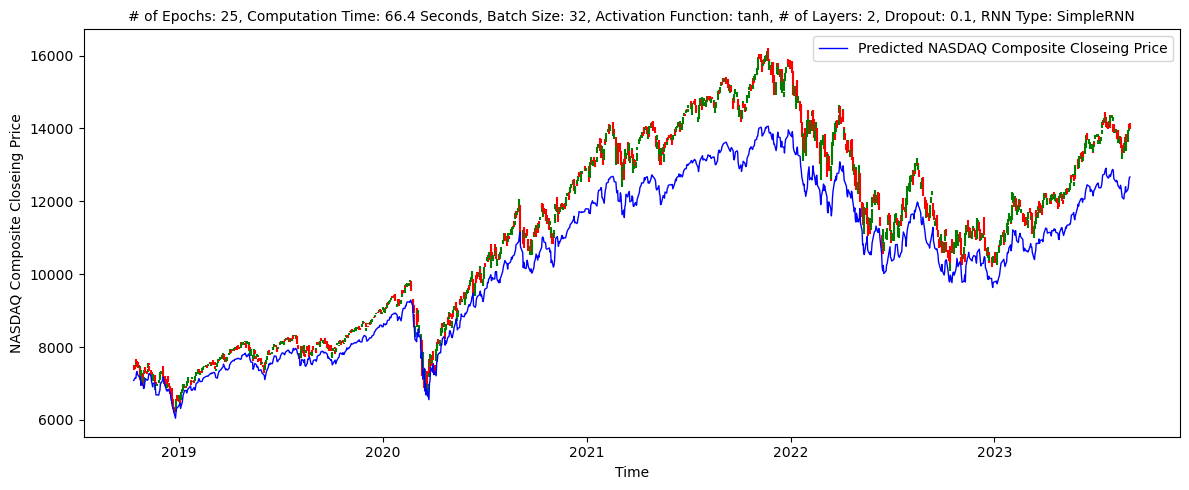

epochs,epochs completed,elapsed time,test RMSE,min train loss,min train RMSE
25,25,66.400000,988.260000,0.000161,0.012210


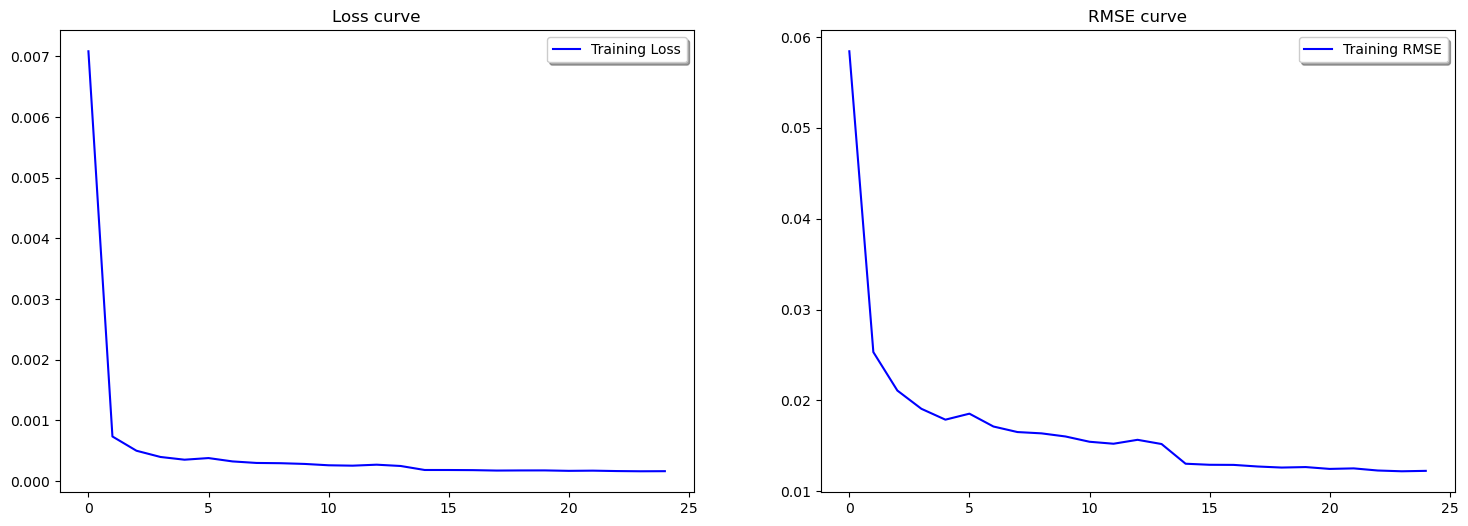

In [3]:
test_df = df_NASDAQ[["Close"]]

rnn_type='SimpleRNN'
num_layers = 2 
activation_function = "tanh"
optimizer = 'rmsprop'
dropout = 0.1
units = 50
epoch = 25
batch_size = 32

look_back = 30
test_coef = 21
ticker = "NASDAQ Composite"
target = "Close"


regressor, X_test, scaler_y, y_test_NASDAQ_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                              target = target,
                                                                                              rnn_type = rnn_type,  
                                                                                              look_back = look_back,
                                                                                              test_coef = test_coef,
                                                                                              dropout = dropout,
                                                                                              epochs = epoch,
                                                                                              num_layers=num_layers,
                                                                                              activation_function=activation_function,
                                                                                              batch_size = batch_size)
predicted_price_NASDAQ_SimpleRNN = regressor.predict(X_test, verbose = 0)
predicted_price_NASDAQ_SimpleRNN = scaler_y.inverse_transform(predicted_price_NASDAQ_SimpleRNN).ravel()

plot_predictions(df = df_NASDAQ,
                 predicted = predicted_price_NASDAQ_SimpleRNN,
                 ticker = ticker,
                 rnn_type = rnn_type,
                 dropout = dropout,
                 epochs = epoch,
                 num_layers=num_layers,
                 activation_function=activation_function,
                 batch_size = batch_size,
                 elapsed_time = elapsed_time)

SimpleRNN_NASDAQ = regression_results(epochs = epoch,
                                      elapsed_time = elapsed_time,
                                      train_loss = history.history['loss'],
                                      train_rmse = history.history['Keras_RMSE'],
                                      y_test = y_test_NASDAQ_Raw,
                                      predicted_price = predicted_price_NASDAQ_SimpleRNN)

display(SimpleRNN_NASDAQ.style.hide())

plot_loss_regression(train_loss = history.history['loss'],
                     train_rmse = history.history['Keras_RMSE'])

### Regression model to predict NASDAQ Close Price using LSTM  - Only Close Price

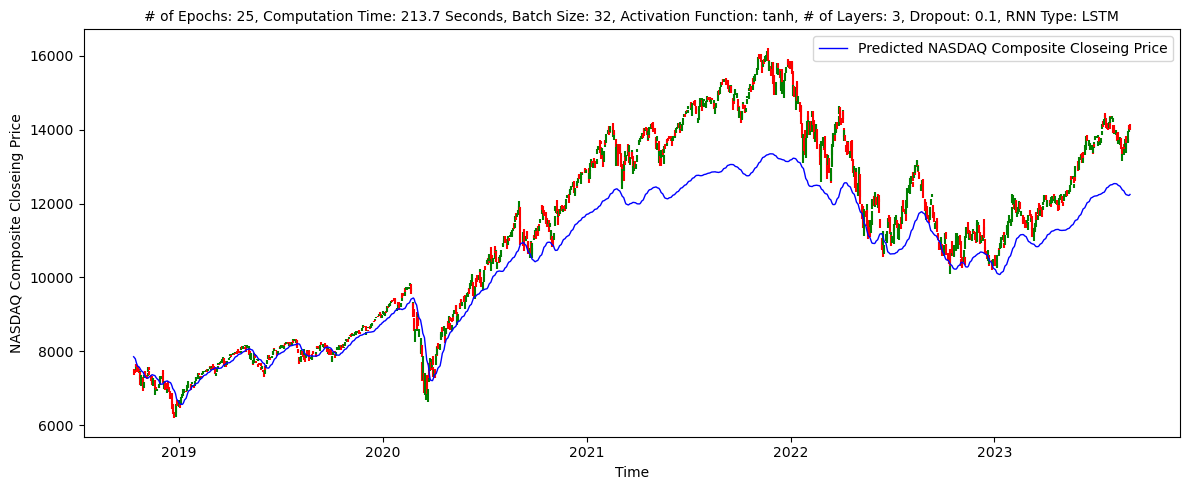

epochs,epochs completed,elapsed time,test RMSE,min train loss,min train RMSE
25,25,213.700000,1099.080000,0.000201,0.013598


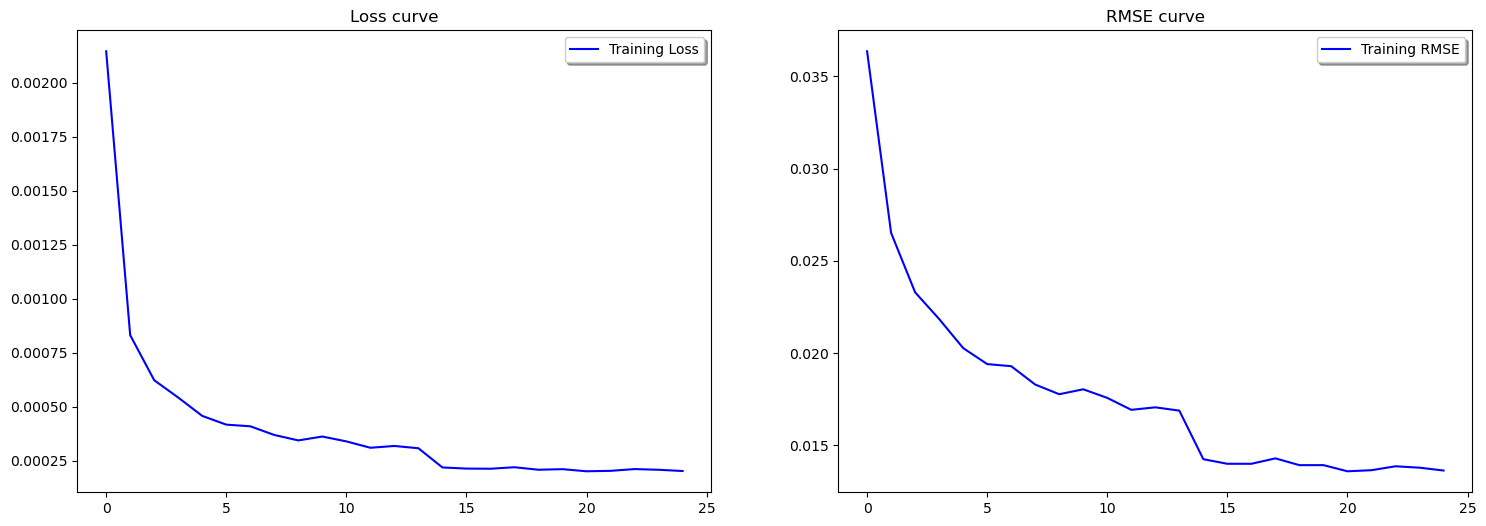

In [4]:
rnn_type='LSTM'
num_layers = 3
optimizer = 'adam'
units = 50
epoch = 25

regressor, X_test, scaler_y, y_test_NASDAQ_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                              target = target,
                                                                                              rnn_type = rnn_type,  
                                                                                              look_back = look_back,
                                                                                              test_coef = test_coef,
                                                                                              dropout = dropout,
                                                                                              epochs = epoch,
                                                                                              num_layers=num_layers,
                                                                                              activation_function=activation_function,
                                                                                              batch_size = batch_size)
predicted_price_NASDAQ_LSTM = regressor.predict(X_test, verbose = 0)
predicted_price_NASDAQ_LSTM = scaler_y.inverse_transform(predicted_price_NASDAQ_LSTM).ravel()

plot_predictions(df = df_NASDAQ,
                 predicted = predicted_price_NASDAQ_LSTM,
                 ticker = ticker,
                 rnn_type = rnn_type,
                 dropout = dropout,
                 epochs = epoch,
                 num_layers=num_layers,
                 activation_function=activation_function,
                 batch_size = batch_size,
                 elapsed_time = elapsed_time)

LSTM_NASDAQ = regression_results(epochs = epoch,
                                      elapsed_time = elapsed_time,
                                      train_loss = history.history['loss'],
                                      train_rmse = history.history['Keras_RMSE'],
                                      y_test = y_test_NASDAQ_Raw,
                                      predicted_price = predicted_price_NASDAQ_LSTM)

display(LSTM_NASDAQ.style.hide())

plot_loss_regression(train_loss = history.history['loss'],
                     train_rmse = history.history['Keras_RMSE'])

### Regression model to predict NASDAQ Close Price using GRU  - Only Close Price

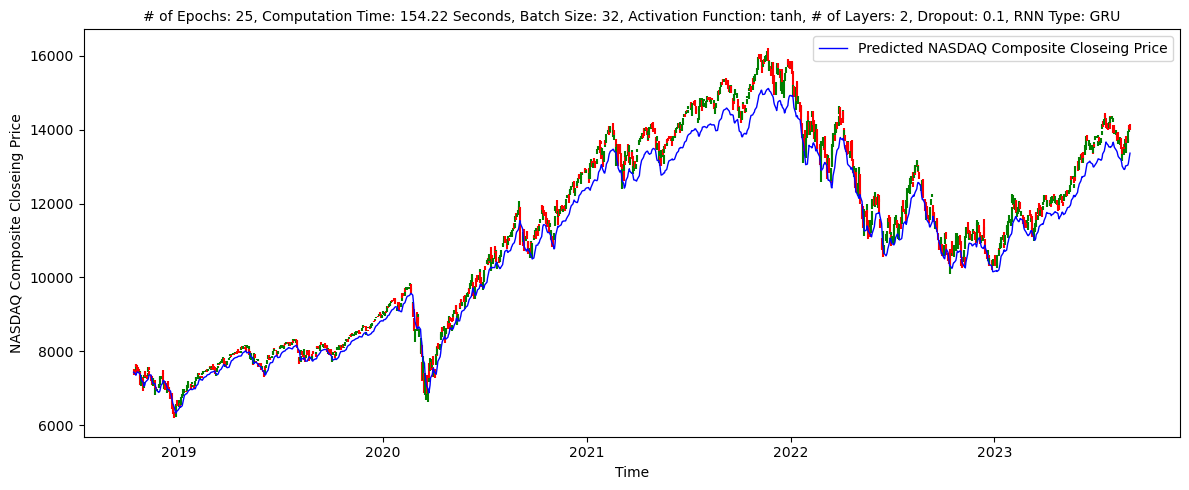

epochs,epochs completed,elapsed time,test RMSE,min train loss,min train RMSE
25,25,154.220000,459.650000,0.000165,0.012323


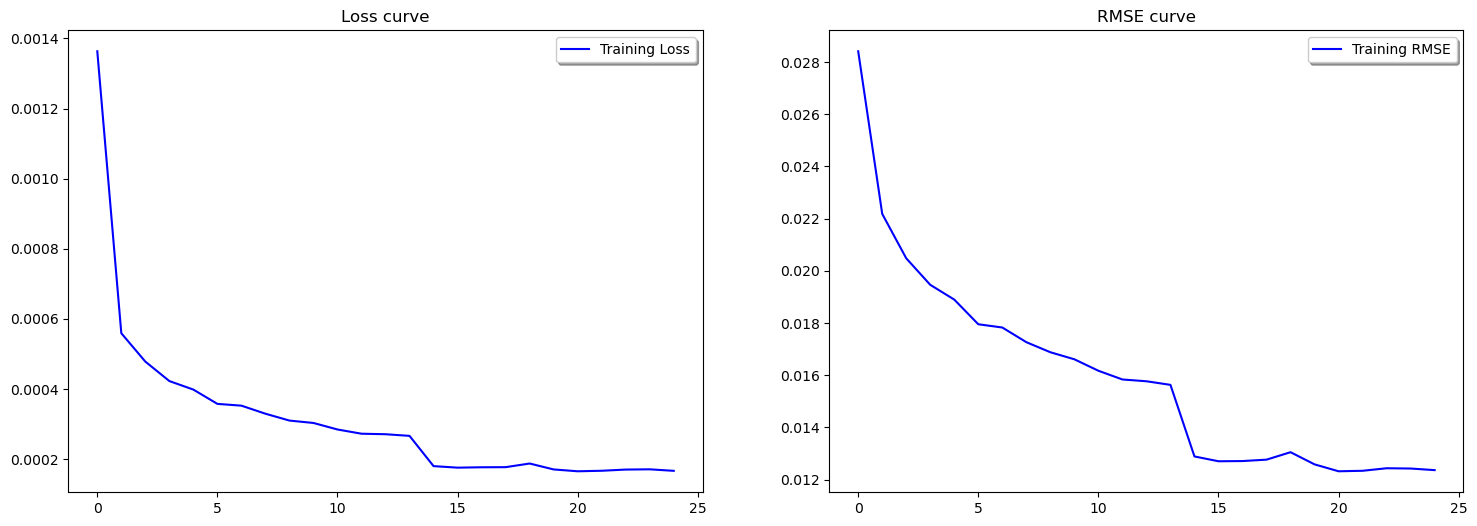

In [5]:
rnn_type='GRU'
num_layers = 2 
activation_function = "tanh"
optimizer = 'sgd'
dropout = 0.1
units = 50
epoch = 25

regressor, X_test, scaler_y, y_test_NASDAQ_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                              target = target,
                                                                                              rnn_type = rnn_type,  
                                                                                              look_back = look_back,
                                                                                              test_coef = test_coef,
                                                                                              dropout = dropout,
                                                                                              epochs = epoch,
                                                                                              num_layers=num_layers,
                                                                                              activation_function=activation_function,
                                                                                              batch_size = batch_size)
predicted_price_NASDAQ_GRU = regressor.predict(X_test, verbose = 0)
predicted_price_NASDAQ_GRU = scaler_y.inverse_transform(predicted_price_NASDAQ_GRU).ravel()

plot_predictions(df = df_NASDAQ,
                 predicted = predicted_price_NASDAQ_GRU,
                 ticker = ticker,
                 rnn_type = rnn_type,
                 dropout = dropout,
                 epochs = epoch,
                 num_layers=num_layers,
                 activation_function=activation_function,
                 batch_size = batch_size,
                 elapsed_time = elapsed_time)

GRU_NASDAQ = regression_results(epochs = epoch,
                                      elapsed_time = elapsed_time,
                                      train_loss = history.history['loss'],
                                      train_rmse = history.history['Keras_RMSE'],
                                      y_test = y_test_NASDAQ_Raw,
                                      predicted_price = predicted_price_NASDAQ_GRU)

display(GRU_NASDAQ.style.hide())

plot_loss_regression(train_loss = history.history['loss'],
                     train_rmse = history.history['Keras_RMSE'])

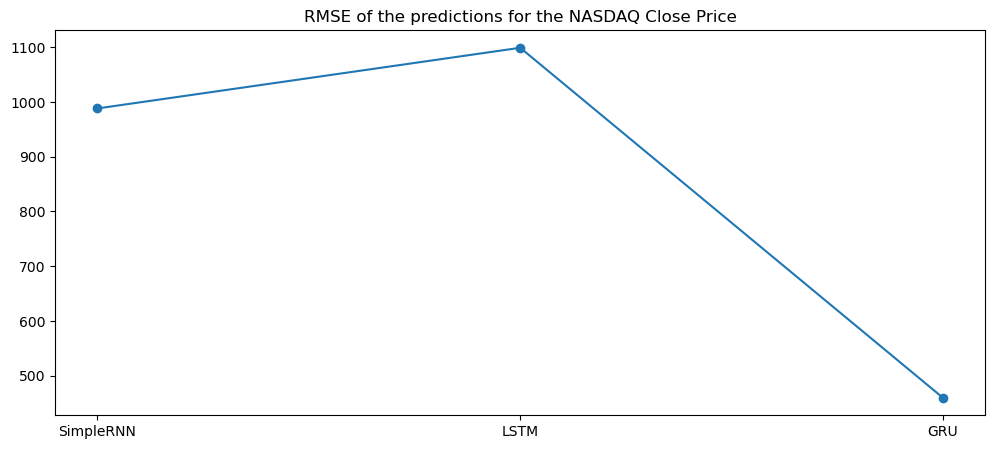

In [6]:
SimpleRNN_NASDAQ_RMSE = SimpleRNN_NASDAQ["test RMSE"].values[0]
LSTM_NASDAQ_RMSE = LSTM_NASDAQ["test RMSE"].values[0]
GRU_NASDAQ_RMSE = GRU_NASDAQ["test RMSE"].values[0]

plt.figure(figsize = (12,5))
plt.plot([SimpleRNN_NASDAQ_RMSE, LSTM_NASDAQ_RMSE, GRU_NASDAQ_RMSE],
        marker = "o")
plt.xticks([0,1,2], ["SimpleRNN", "LSTM", "GRU"])
plt.title("RMSE of the predictions for the NASDAQ Close Price")
plt.show()

## It seems like we will be rich so fast!!

Results look soo good already!! But does regression model works well at all? Let's take a closer look.

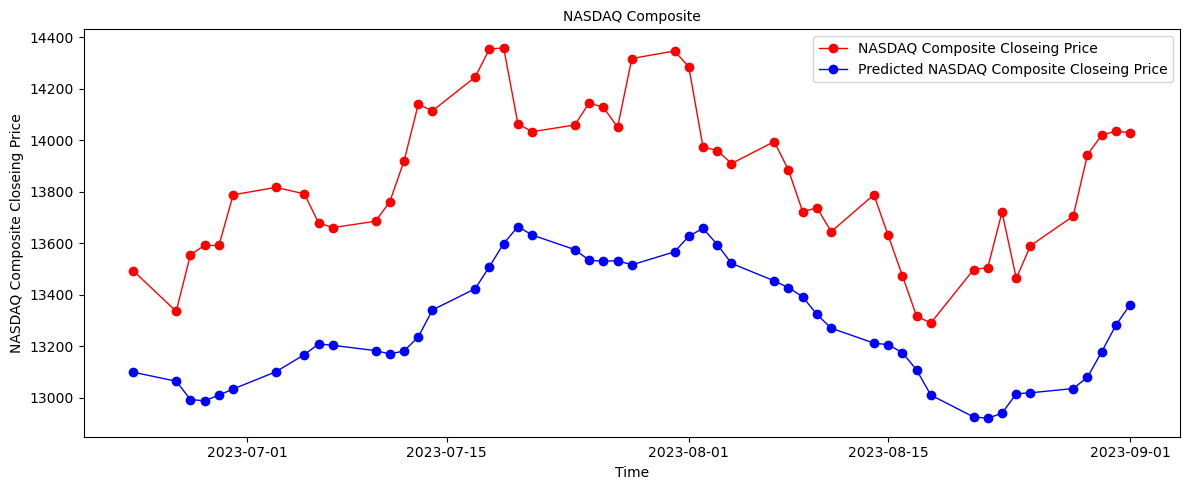

In [7]:
plot_predictions(df = df_NASDAQ,
                 predicted = predicted_price_NASDAQ_GRU[-50:],
                 ticker = "NASDAQ Composite",
                 line=True)

Let's make some naive predictions. Suppose our model predicts the closing price for every day as the closing price of the previous day, implying that we expect no change in the price. While this might sound like a simplistic approach, it's worthwhile to evaluate the performance of such a model and compare its results with our advanced deep learning models.

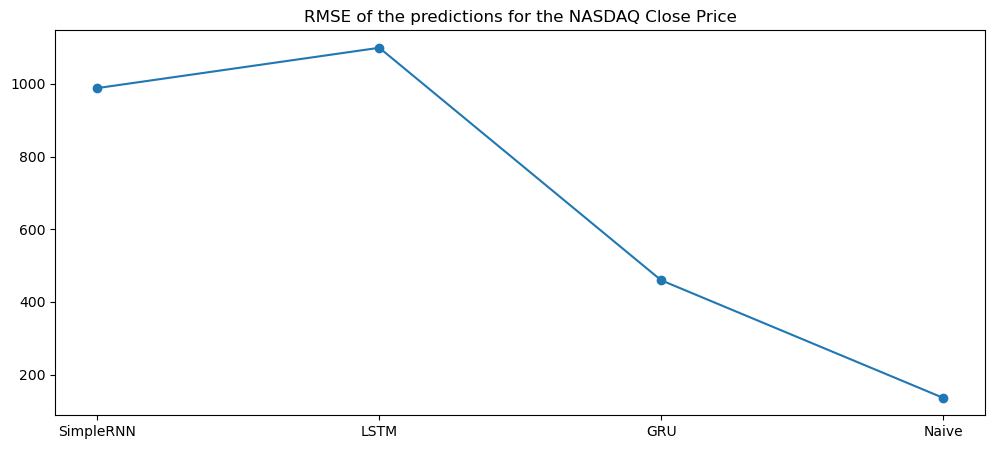

In [8]:
naive_NASDAQ = df_NASDAQ.Close.shift(1)[-50:]
naive_NASDAQ_RMSE = met.mean_squared_error(df_NASDAQ.Close[-50:], naive_NASDAQ, squared=False)

plt.figure(figsize = (12,5))
plt.plot([SimpleRNN_NASDAQ_RMSE, LSTM_NASDAQ_RMSE, GRU_NASDAQ_RMSE, naive_NASDAQ_RMSE],
        marker = "o")
plt.xticks([0,1,2,3], ["SimpleRNN", "LSTM", "GRU", "Naive"])
plt.title("RMSE of the predictions for the NASDAQ Close Price")
plt.show()

## What have we learned?

- The GRU outperforms both LSTM and SimpleRNN in regression tasks. However, surprisingly, a naive prediction method surpasses all of them.
- The closing price of the previous day is not a reliable predictor for the next day's closing price.

## Is RMSE a Good Indicator for Measuring the Success of Our Models?

The objective of this project is to generate profits through buying and selling stocks based on the predictions of statistical models. Up to this point, our focus has been on predicting the exact closing prices for the next day. However, one might ask: Do we actually need to know the next day's exact closing price to make money? For example, if our model predicts a 1% increase in stock price for the next day and the stock actually goes up by 2%, the RMSE (Root Mean Square Error) would increase, even though we would have profited from the prediction. What truly harms us is when the model predicts an increase and the stock price actually declines.

Consequently, I'm shifting my focus towards classifying predictions as either green or red candles and will assess the model based on classification errors.

### SimpleRNN Classification Results  - Only Close Price

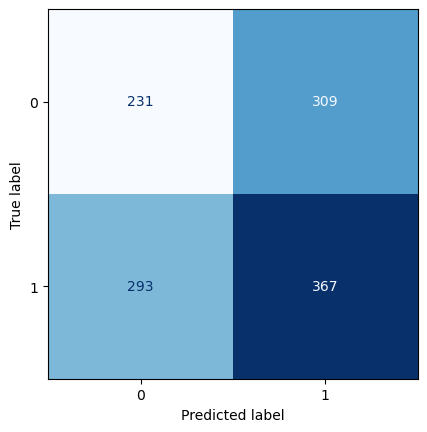

In [9]:
func_list = ['SimpleRNN', "Only Close Price", SimpleRNN_NASDAQ["test RMSE"].values[0]]

y_pred_classified = (pd.Series(predicted_price_NASDAQ_SimpleRNN).pct_change()[-1200:] > 0).astype(int)
y_test_classified = (pd.Series(y_test_NASDAQ_Raw).pct_change()[-1200:] > 0).astype(int)

cf_matrix = met.confusion_matrix(y_test_classified, y_pred_classified)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test_classified, y_pred_classified)
func_list.append(accuracy)
precision = met.precision_score(y_test_classified, y_pred_classified)
func_list.append(precision)
recall = met.recall_score(y_test_classified, y_pred_classified)
func_list.append(recall)
f1 = met.f1_score(y_test_classified, y_pred_classified)
func_list.append(f1)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

### LSTM Classification Results - Only Close Price

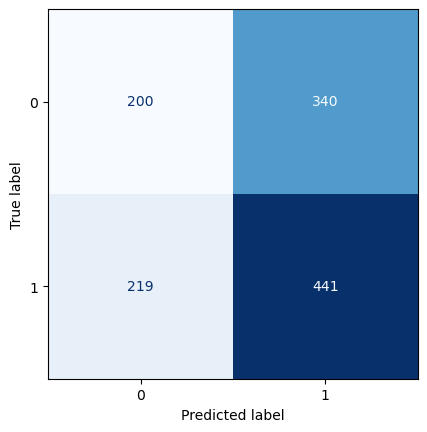

In [10]:
y_pred_classified = (pd.Series(predicted_price_NASDAQ_LSTM).pct_change()[-1200:] > 0).astype(int)
y_test_classified = (pd.Series(y_test_NASDAQ_Raw).pct_change()[-1200:] > 0).astype(int)

func_list = ['LSTM', "Only Close Price", LSTM_NASDAQ["test RMSE"].values[0]]

cf_matrix = met.confusion_matrix(y_test_classified, y_pred_classified)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test_classified, y_pred_classified)
func_list.append(accuracy)
precision = met.precision_score(y_test_classified, y_pred_classified)
func_list.append(precision)
recall = met.recall_score(y_test_classified, y_pred_classified)
func_list.append(recall)
f1 = met.f1_score(y_test_classified, y_pred_classified)
func_list.append(f1)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

### GRU Classification Results - Only Close Price

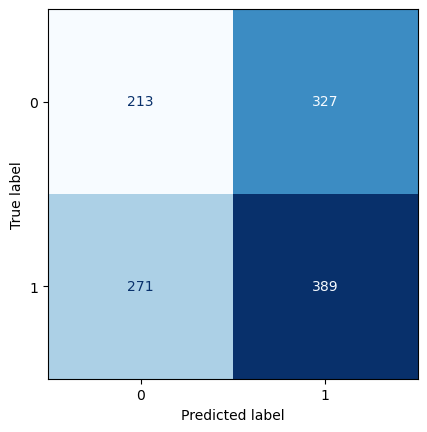

In [11]:
y_pred_classified = (pd.Series(predicted_price_NASDAQ_GRU).pct_change()[-1200:] > 0).astype(int)
y_test_classified = (pd.Series(y_test_NASDAQ_Raw).pct_change()[-1200:] > 0).astype(int)

func_list = ['GRU', "Only Close Price", GRU_NASDAQ["test RMSE"].values[0]]

cf_matrix = met.confusion_matrix(y_test_classified, y_pred_classified)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test_classified, y_pred_classified)
func_list.append(accuracy)
precision = met.precision_score(y_test_classified, y_pred_classified)
func_list.append(precision)
recall = met.recall_score(y_test_classified, y_pred_classified)
func_list.append(recall)
f1 = met.f1_score(y_test_classified, y_pred_classified)
func_list.append(f1)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

### Naive Classification Results - Only Close Price

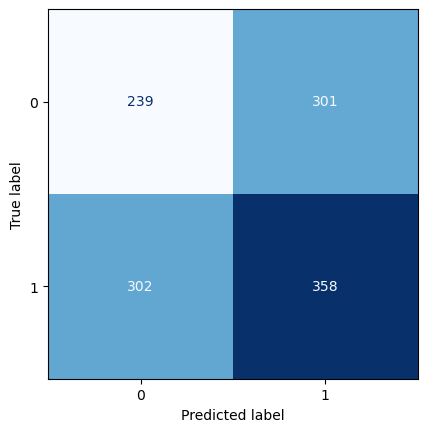

In [12]:
func_list = ['Naive Prediction', "Only Close Price", naive_NASDAQ_RMSE]

y_pred_classified = (df_NASDAQ.Close.shift(-1).pct_change() > 0).astype(int)[-1200:].values
y_test_classified = (pd.Series(y_test_NASDAQ_Raw).pct_change()[-1200:] > 0).astype(int)

cf_matrix = met.confusion_matrix(y_test_classified, y_pred_classified)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test_classified, y_pred_classified)
func_list.append(accuracy)
precision = met.precision_score(y_test_classified, y_pred_classified)
func_list.append(precision)
recall = met.recall_score(y_test_classified, y_pred_classified)
func_list.append(recall)
f1 = met.f1_score(y_test_classified, y_pred_classified)
func_list.append(f1)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

In [13]:
df_results_base = pd.DataFrame(explanations, columns=["Model", "Explanation", "RMSE", "TN", "FP", "FN", "TP", "Accuracy", "Precision", "Recall", "F1"])
df_results_base.set_index('Model', inplace=True)
df_results_base

,Explanation,RMSE,TN,FP,FN,TP,Accuracy,Precision,Recall,F1
Model,,,,,,,,,,
SimpleRNN,Only Close Price,988.26,231,309,293,367,0.50,0.54,0.56,0.55
LSTM,Only Close Price,1099.08,200,340,219,441,0.53,0.56,0.67,0.61
GRU,Only Close Price,459.65,213,327,271,389,0.50,0.54,0.59,0.57
Naive Prediction,Only Close Price,136.37,239,301,302,358,0.50,0.54,0.54,0.54


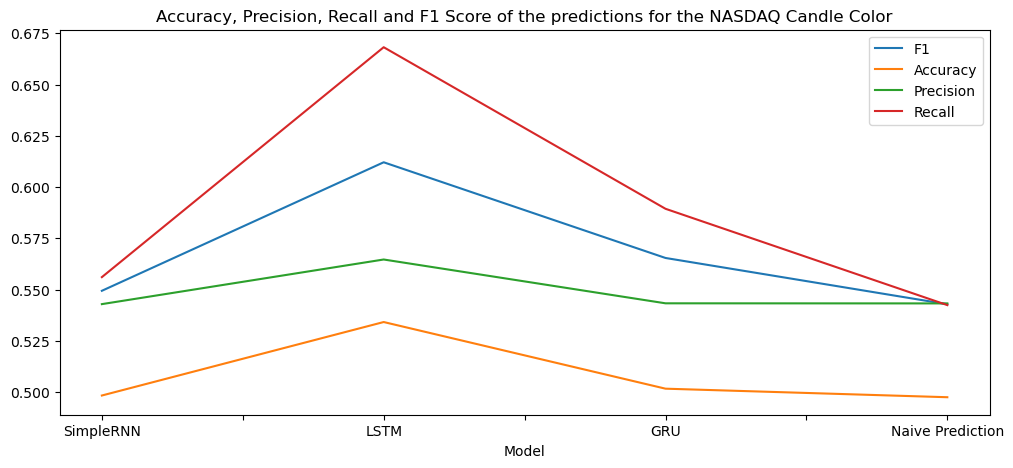

In [14]:
df_results_base[["F1", "Accuracy", "Precision","Recall"]].plot(figsize = (12,5))
plt.title("Accuracy, Precision, Recall and F1 Score of the predictions for the NASDAQ Candle Color")
plt.show()

LSTM models appear to outperform other methods in predicting the color of stock candles. However, should our primary objective be to predict the color of these candles? The color of a candle represents whether the percentage change is positive or negative, but what if the conditions for our predictions are met during the trading day, before the final color of the candle is determined?

## Are Accuracy, Precision, Recall, and F1 Score Good Indicators for Measuring the Success of Our Models?
Should our primary focus be on predicting the color of stock candles? A candle's color represents whether the stock experienced a positive or negative percentage change. But what if our predictive criteria are met during the trading day, before the candle's final color is established?

Up until now, we've been attempting to predict the NASDAQ's actual closing prices and to classify daily candles. It's essential to revisit the primary goals of this project:

- **Avoid losing money**.
- **Generate profits**.

RMSE (Root Mean Square Error) doesn't necessarily serve as an effective indicator for our purposes. We don't need to predict the exact closing price or the exact percentage change to meet our objectives. For instance, if we predict a 1% market increase and it rises only by 0.5%, we haven't actually lost money. At the end of the trading day, we can evaluate our position and decide whether to lock in a 0.5% profit or hold our position for the next day. Such a scenario would align with our objectives but would adversely affect the RMSE metric. Additionally, our predictive conditions might be met during the trading day, even if the candle's final color changes by the close of trading.

As a result, we need to develop a custom indicator to gauge the efficacy of our model accurately. This indicator would assess the predicted candle color; if the candle's actual color matches our prediction, the error for that instance will be zero. Similarly, if our predictive conditions are met during the trading day, the error for that instance will also be zero. For all other cases, the error will be the root mean square error between the predicted and actual percentage changes.

In [29]:
def custom_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    signs_match = tf.math.sign(y_true) == tf.math.sign(y_pred)
    error = tf.where(signs_match, 0.0, tf.square(y_true - y_pred))
    loss = tf.reduce_mean(error)
    return loss

def profit(df, y_pred):
    df = df[-len(y_pred):]
    actual_change = df["pct_close"].values
    high = df["pct_high_from_prev_close"].values
    low = df["pct_low_from_prev_close"].values
    
    profit = 0
    daily_profit = []
    cumulative_profit = []
    compounded_profit = 1
    compounded_profit_list = []

    for idx, i in enumerate(y_pred):
        daily = 0
        if i > 0:
            if actual_change[idx] > 0:
                daily = min(abs(i), abs(actual_change[idx]))
            else:
                if high[idx] >= abs(i):
                    daily = abs(i)
                else:
                    daily = -abs(actual_change[idx])
        else:
            if actual_change[idx] < 0:
                daily = min(abs(i), abs(actual_change[idx]))
            else:
                if low[idx] <= abs(i):
                    daily = abs(i)
                else:
                    daily = -abs(actual_change[idx])
        
        daily_profit.append(daily)
        profit += daily
        cumulative_profit.append(profit)

        compounded_profit *= (1 + daily / 100)
        compounded_profit_list.append((compounded_profit - 1) * 100)

    profit_df = pd.DataFrame({
        'daily_profit': daily_profit,
        'Cumulative Profit': cumulative_profit,
        'Compounded Profit': compounded_profit_list
    }, index=df.index)

    return profit, profit_df

def loss(df, y_pred):
    df = df[-len(y_pred):]
    actual_change = df["pct_close"].values
    high = df["pct_high_from_prev_close"].values
    low = df["pct_low_from_prev_close"].values
    
    loss_days = []

    for idx, i in enumerate(y_pred):
        
        if i > 0:
            if actual_change[idx] > 0:
                loss_days.append(0)
            else:
                if high[idx] >= abs(i):
                    loss_days.append(0)
                else:
                    loss_days.append(1)
        else:
            if actual_change[idx] < 0:
                loss_days.append(0)
            else:
                if low[idx] <= abs(i):
                    loss_days.append(0)
                else:
                    loss_days.append(1)
    return loss_days

## Target = "pt_close"

In [16]:
info = [] #Explanation, Cumulative Profit, Compounded Profit, Nr of Loss Days, Nr of Profit Days

df_NASDAQ["pct_close"]  = df_NASDAQ["Close"].pct_change() * 100
df_NASDAQ["pct_open_from_prev_close"]   = pd.Series((df_NASDAQ['Open'] - df_NASDAQ['Close'].shift(1)) / df_NASDAQ['Close'].shift(1)) * 100
df_NASDAQ["pct_high_from_prev_close"] = ((df_NASDAQ['High'] - df_NASDAQ['Close'].shift(1)) / df_NASDAQ['Close'].shift(1)) * 100
df_NASDAQ["pct_low_from_prev_close"] = ((df_NASDAQ['Low'] - df_NASDAQ['Close'].shift(1)) / df_NASDAQ['Close'].shift(1)) * 100
df_NASDAQ = df_NASDAQ[df_NASDAQ.Volume != 0].drop(["Dividends", "Stock Splits"], axis = 1)

df_NASDAQ.tail()

,Open,High,Low,Close,Volume,pct_close,pct_open_from_prev_close,pct_high_from_prev_close,pct_low_from_prev_close
2023-08-28,13695.36,13735.98,13626.64,13705.13,3666680000,0.84,0.77,1.07,0.26
2023-08-29,13687.23,13959.81,13677.06,13943.76,4748180000,1.74,-0.13,1.86,-0.20
2023-08-30,13961.77,14050.82,13924.20,14019.31,4364600000,0.54,0.13,0.77,-0.14
2023-08-31,14041.54,14114.67,14010.48,14034.97,4568610000,0.11,0.16,0.68,-0.06
2023-09-01,14130.00,14149.62,13982.42,14029.04,2931442000,-0.04,0.68,0.82,-0.37


### SimpleRNN

epochs,epochs completed,elapsed time,test RMSE,min train loss,min train RMSE
25,25,45.600000,1.660000,0.002838,0.051787


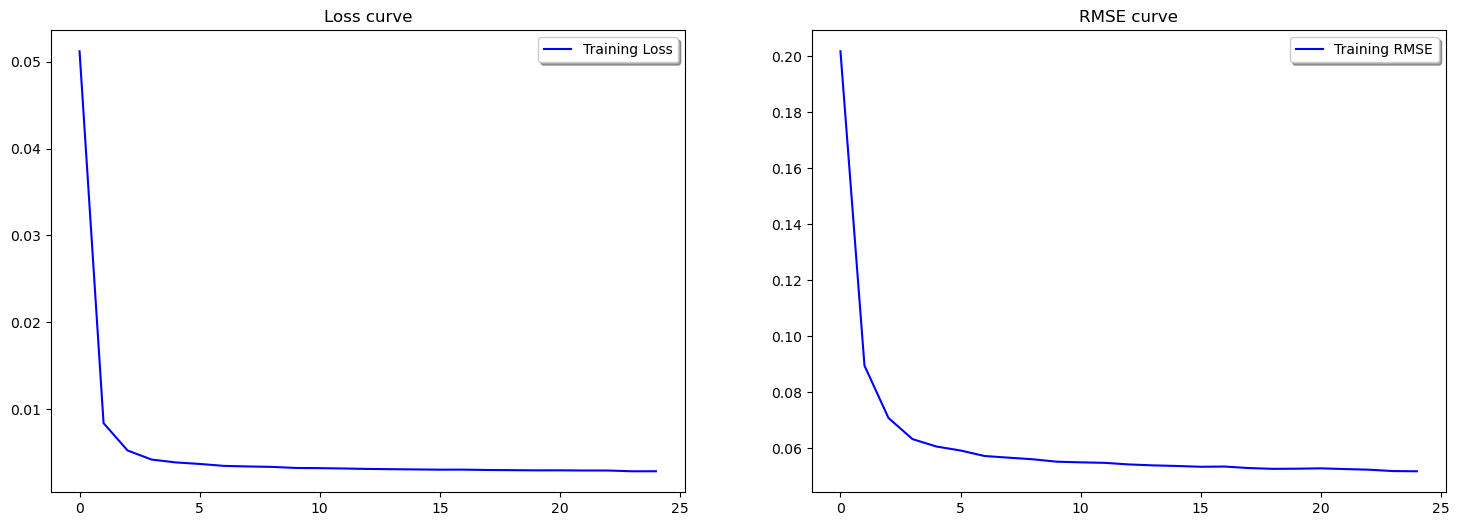

In [17]:
test_df = df_NASDAQ

rnn_type='SimpleRNN'
target = "pct_close"
num_layers = 2 
activation_function = "tanh"
optimizer = 'rmsprop'
dropout = 0.1
units = 50
epoch = 25
batch_size = 32

look_back = 30
test_coef = 21
ticker = "NASDAQ Composite"


regressor, X_test, scaler_y, y_test_NASDAQ_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                              target = target,
                                                                                              rnn_type = rnn_type,  
                                                                                              look_back = look_back,
                                                                                              test_coef = test_coef,
                                                                                              dropout = dropout,
                                                                                              epochs = epoch,
                                                                                              num_layers=num_layers,
                                                                                              activation_function=activation_function,
                                                                                              batch_size = batch_size)
predicted_price_NASDAQ_SimpleRNN_Profit = regressor.predict(X_test, verbose = 0)
predicted_price_NASDAQ_SimpleRNN_Profit = scaler_y.inverse_transform(predicted_price_NASDAQ_SimpleRNN_Profit).ravel()

SimpleRNN_Profit_NASDAQ = regression_results(epochs = epoch,
                                      elapsed_time = elapsed_time,
                                      train_loss = history.history['loss'],
                                      train_rmse = history.history['Keras_RMSE'],
                                      y_test = y_test_NASDAQ_Raw,
                                      predicted_price = predicted_price_NASDAQ_SimpleRNN_Profit)

display(SimpleRNN_Profit_NASDAQ.style.hide())

plot_loss_regression(train_loss = history.history['loss'],
                     train_rmse = history.history['Keras_RMSE'])

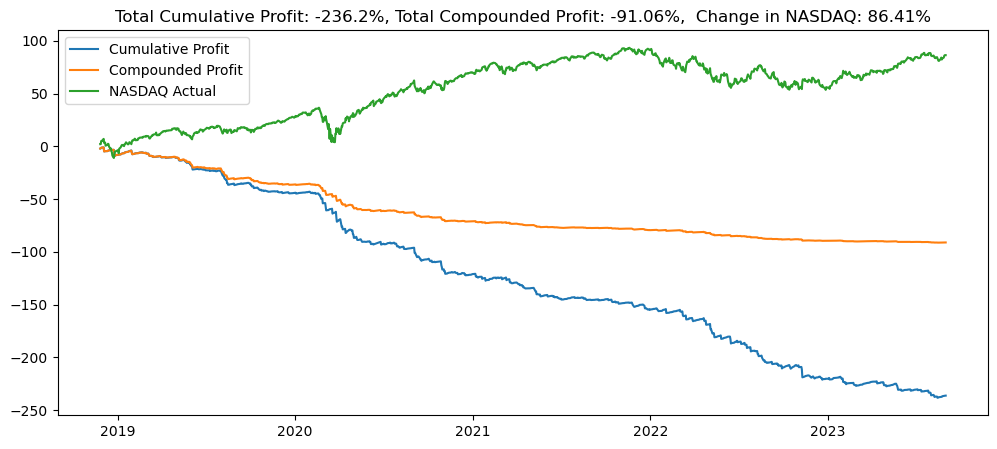

In [18]:
total, profitDf = profit(df_NASDAQ, predicted_price_NASDAQ_SimpleRNN_Profit[-1200:])
profitDf["NASDAQ Actual"] = np.cumsum(y_test_NASDAQ_Raw[-1200:])

profitDf[['Cumulative Profit', 'Compounded Profit', "NASDAQ Actual"]].plot(figsize = (12,5))
plt.title(f'Total Cumulative Profit: {round(profitDf["Cumulative Profit"][-1], 2)}%, Total Compounded Profit: {round(profitDf["Compounded Profit"][-1], 2)}%,  Change in NASDAQ: {round(profitDf["NASDAQ Actual"][-1], 2)}%')
plt.show()

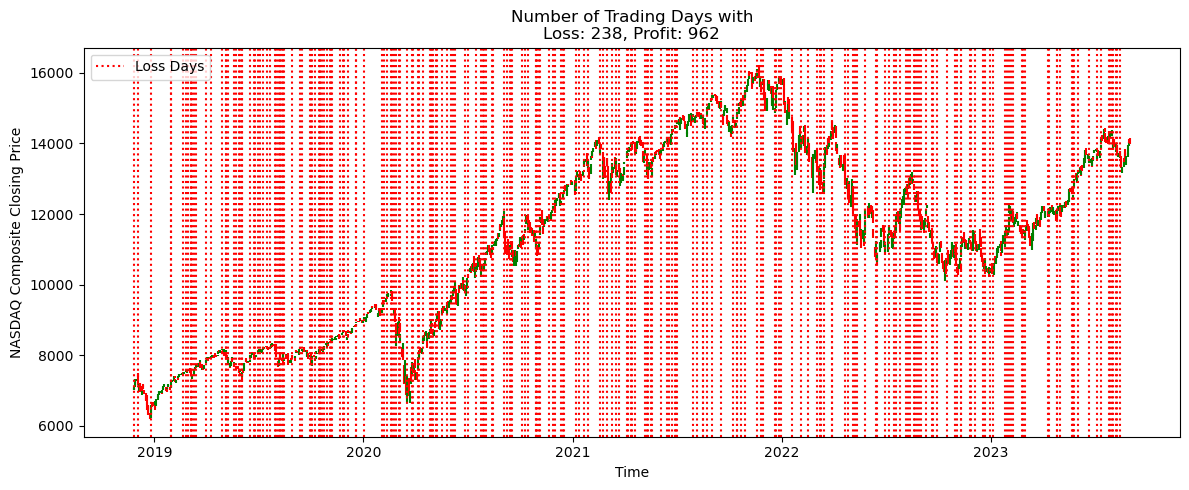

In [19]:
loss_arr = loss(df_NASDAQ, predicted_price_NASDAQ_SimpleRNN_Profit[-1200:])

line = ["SimpleRNN Without Custom Loss Function"]
line.append(round(profitDf["Cumulative Profit"][-1], 2))
line.append(round(profitDf["Compounded Profit"][-1], 2))
line.append(sum(loss_arr))
line.append(len(loss_arr) - sum(loss_arr))
info.append(line)

plot_loss_days(df_NASDAQ, loss_arr, "NASDAQ Composite")

### LSTM

epochs,epochs completed,elapsed time,test RMSE,min train loss,min train RMSE
25,25,98.860000,1.640000,0.002942,0.052367


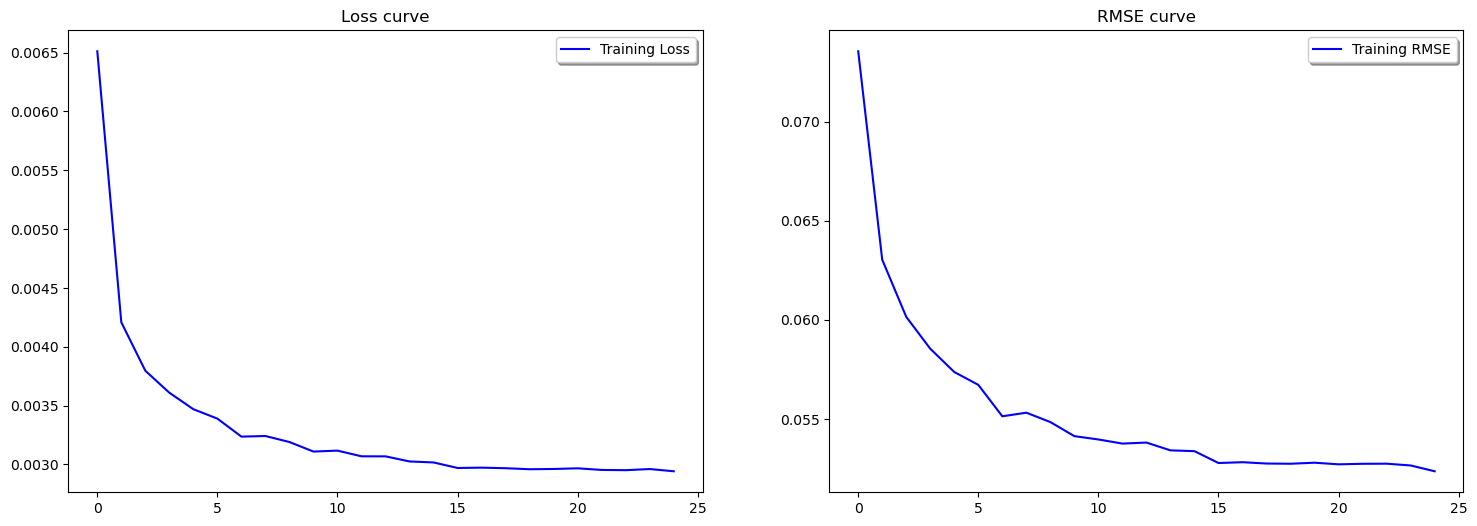

In [20]:
rnn_type='LSTM'
num_layers = 2 
activation_function = "tanh"
optimizer = 'rmsprop'
dropout = 0.1
units = 50
epoch = 25
batch_size = 32

look_back = 30
test_coef = 21
ticker = "NASDAQ Composite"


regressor, X_test, scaler_y, y_test_NASDAQ_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                              target = target,
                                                                                              rnn_type = rnn_type,  
                                                                                              look_back = look_back,
                                                                                              test_coef = test_coef,
                                                                                              dropout = dropout,
                                                                                              epochs = epoch,
                                                                                              num_layers=num_layers,
                                                                                              activation_function=activation_function,
                                                                                              batch_size = batch_size)
predicted_price_NASDAQ_LSTM_Profit = regressor.predict(X_test, verbose = 0)
predicted_price_NASDAQ_LSTM_Profit = scaler_y.inverse_transform(predicted_price_NASDAQ_LSTM_Profit).ravel()

LSTM_Profit_NASDAQ = regression_results(epochs = epoch,
                                      elapsed_time = elapsed_time,
                                      train_loss = history.history['loss'],
                                      train_rmse = history.history['Keras_RMSE'],
                                      y_test = y_test_NASDAQ_Raw,
                                      predicted_price = predicted_price_NASDAQ_LSTM_Profit)

display(LSTM_Profit_NASDAQ.style.hide())

plot_loss_regression(train_loss = history.history['loss'],
                     train_rmse = history.history['Keras_RMSE'])

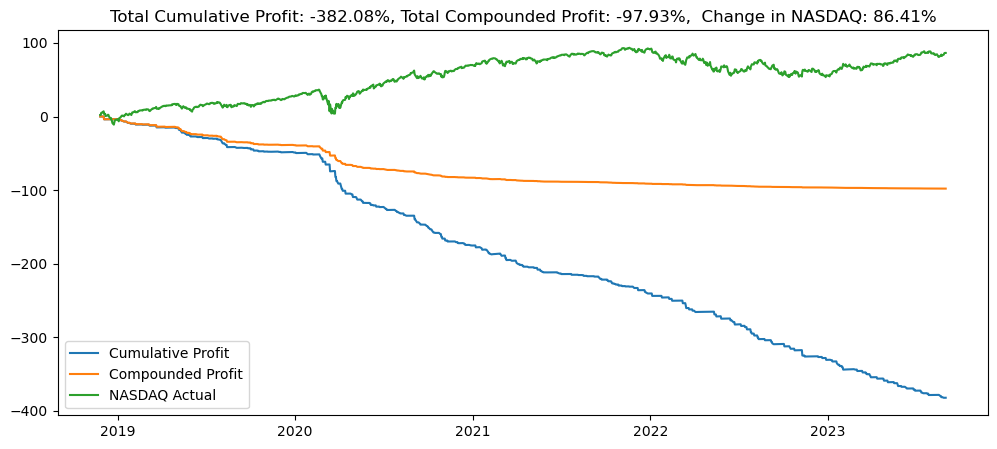

In [21]:
total, profitDf = profit(df_NASDAQ, predicted_price_NASDAQ_LSTM_Profit[-1200:])
profitDf["NASDAQ Actual"] = np.cumsum(y_test_NASDAQ_Raw[-1200:])

profitDf[['Cumulative Profit', 'Compounded Profit', "NASDAQ Actual"]].plot(figsize = (12,5))
plt.title(f'Total Cumulative Profit: {round(profitDf["Cumulative Profit"][-1], 2)}%, Total Compounded Profit: {round(profitDf["Compounded Profit"][-1], 2)}%,  Change in NASDAQ: {round(profitDf["NASDAQ Actual"][-1], 2)}%')
plt.show()

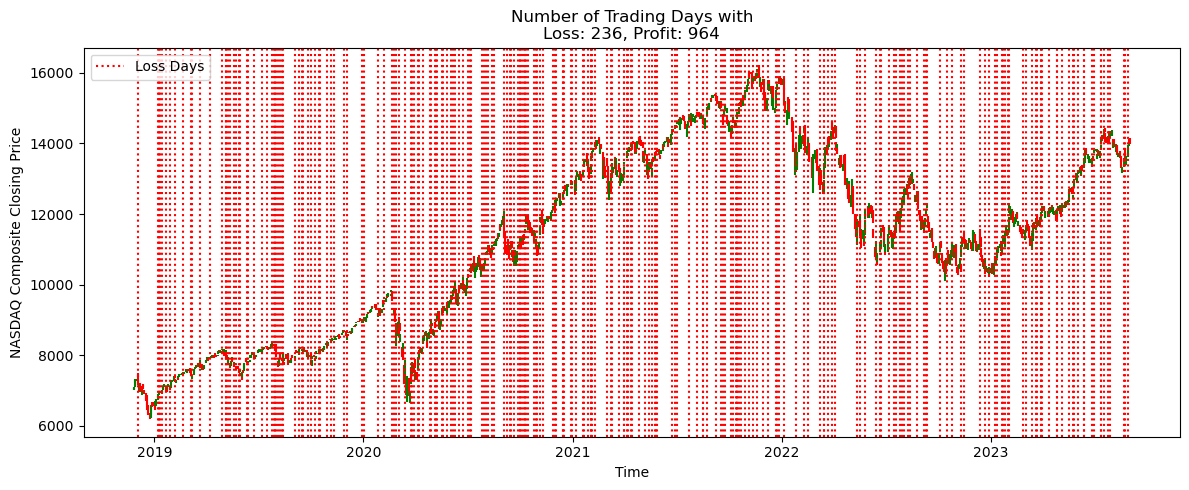

In [22]:
loss_arr = loss(df_NASDAQ, predicted_price_NASDAQ_LSTM_Profit[-1200:])

line = ["LSTM Without Custom Loss Function"]
line.append(round(profitDf["Cumulative Profit"][-1], 2))
line.append(round(profitDf["Compounded Profit"][-1], 2))
line.append(sum(loss_arr))
line.append(len(loss_arr) - sum(loss_arr))
info.append(line)

plot_loss_days(df_NASDAQ, loss_arr, "NASDAQ Composite")

### GRU

epochs,epochs completed,elapsed time,test RMSE,min train loss,min train RMSE
25,24,79.600000,1.640000,0.002991,0.052966


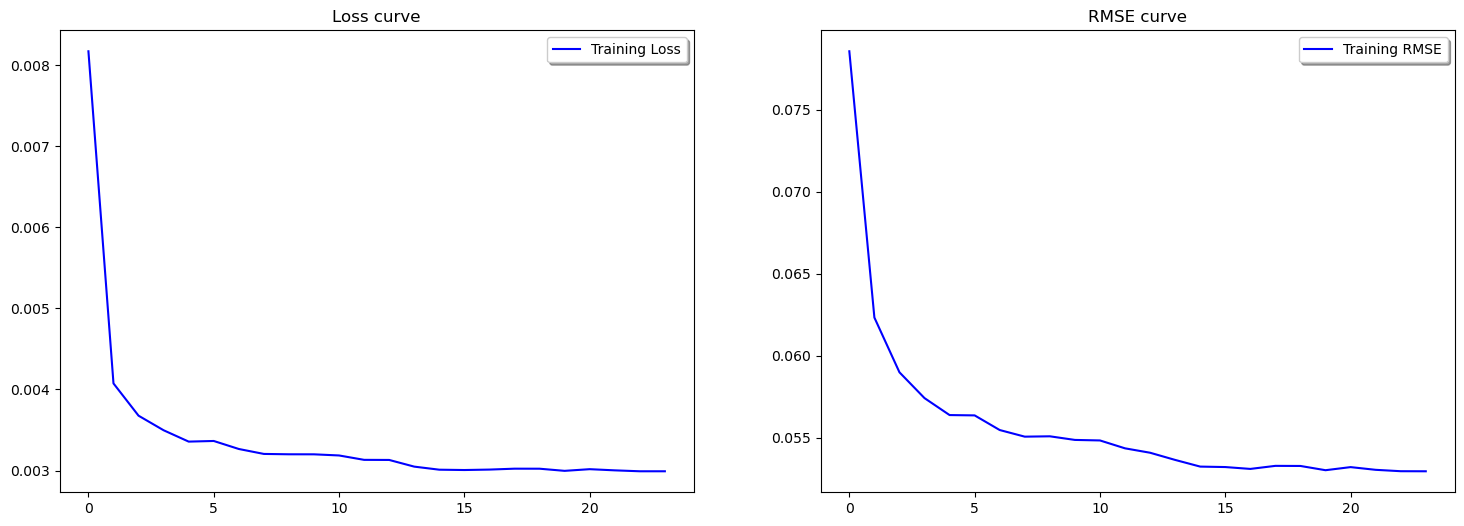

In [23]:
rnn_type='GRU'
num_layers = 2 
activation_function = "tanh"
optimizer = 'rmsprop'
dropout = 0.1
units = 50
epoch = 25
batch_size = 32

look_back = 30
test_coef = 21
ticker = "NASDAQ Composite"


regressor, X_test, scaler_y, y_test_NASDAQ_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                              target = target,
                                                                                              rnn_type = rnn_type,  
                                                                                              look_back = look_back,
                                                                                              test_coef = test_coef,
                                                                                              dropout = dropout,
                                                                                              epochs = epoch,
                                                                                              num_layers=num_layers,
                                                                                              activation_function=activation_function,
                                                                                              batch_size = batch_size)
predicted_price_NASDAQ_GRU_Profit = regressor.predict(X_test, verbose = 0)
predicted_price_NASDAQ_GRU_Profit = scaler_y.inverse_transform(predicted_price_NASDAQ_GRU_Profit).ravel()

GRU_Profit_NASDAQ = regression_results(epochs = epoch,
                                      elapsed_time = elapsed_time,
                                      train_loss = history.history['loss'],
                                      train_rmse = history.history['Keras_RMSE'],
                                      y_test = y_test_NASDAQ_Raw,
                                      predicted_price = predicted_price_NASDAQ_GRU_Profit)

display(GRU_Profit_NASDAQ.style.hide())

plot_loss_regression(train_loss = history.history['loss'],
                     train_rmse = history.history['Keras_RMSE'])

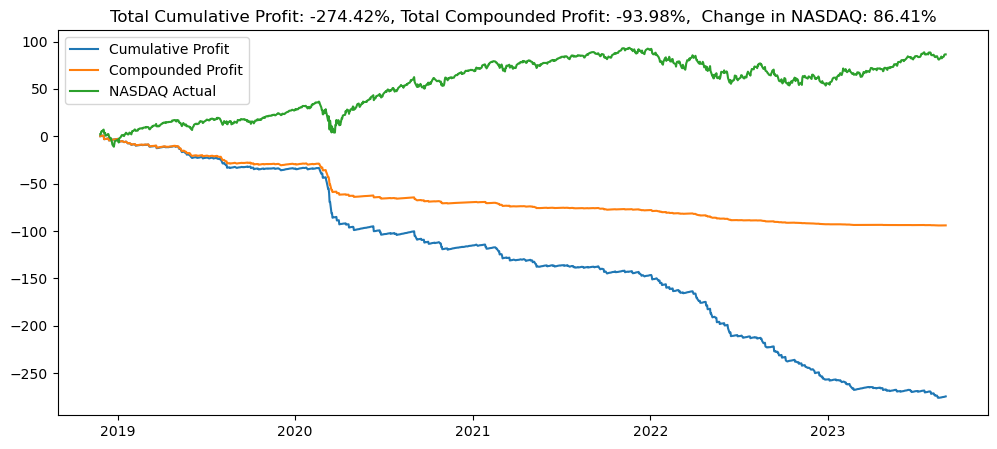

In [24]:
total, profitDf = profit(df_NASDAQ, predicted_price_NASDAQ_GRU_Profit[-1200:])
profitDf["NASDAQ Actual"] = np.cumsum(y_test_NASDAQ_Raw[-1200:])

profitDf[['Cumulative Profit', 'Compounded Profit', "NASDAQ Actual"]].plot(figsize = (12,5))
plt.title(f'Total Cumulative Profit: {round(profitDf["Cumulative Profit"][-1], 2)}%, Total Compounded Profit: {round(profitDf["Compounded Profit"][-1], 2)}%,  Change in NASDAQ: {round(profitDf["NASDAQ Actual"][-1], 2)}%')
plt.show()

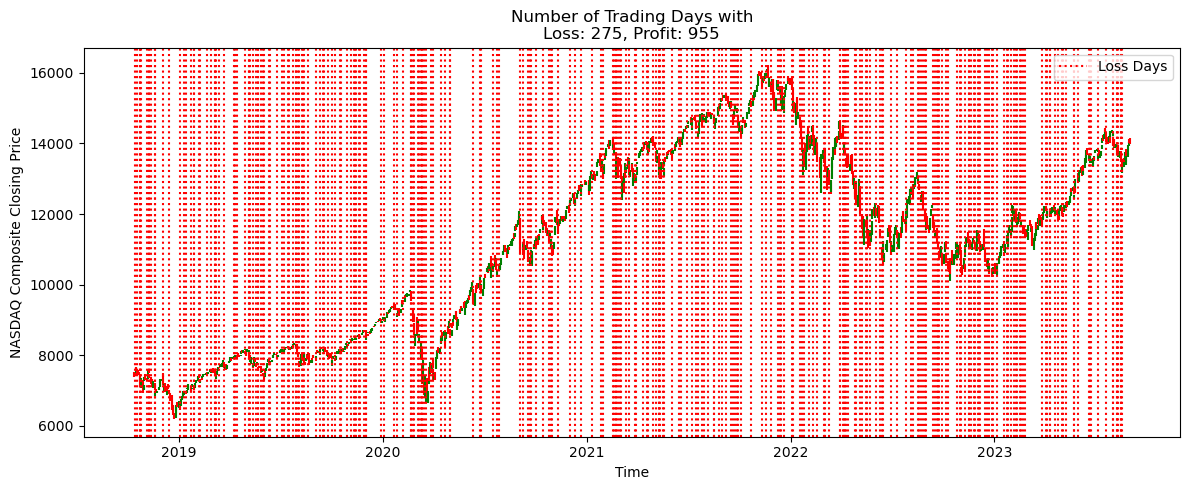

In [25]:
loss_arr = loss(df_NASDAQ, predicted_price_NASDAQ_GRU_Profit[-1230:])

line = ["GRU Without Custom Loss Function"]
line.append(round(profitDf["Cumulative Profit"][-1], 2))
line.append(round(profitDf["Compounded Profit"][-1], 2))
line.append(sum(loss_arr))
line.append(len(loss_arr) - sum(loss_arr))
info.append(line)

plot_loss_days(df_NASDAQ, loss_arr, "NASDAQ Composite")

## Training The Models Using Custom Indicator

### SimpleRNN

epochs,epochs completed,elapsed time,test RMSE,min train loss,min train RMSE
25,25,48.750000,1.660000,0.002827,0.051575


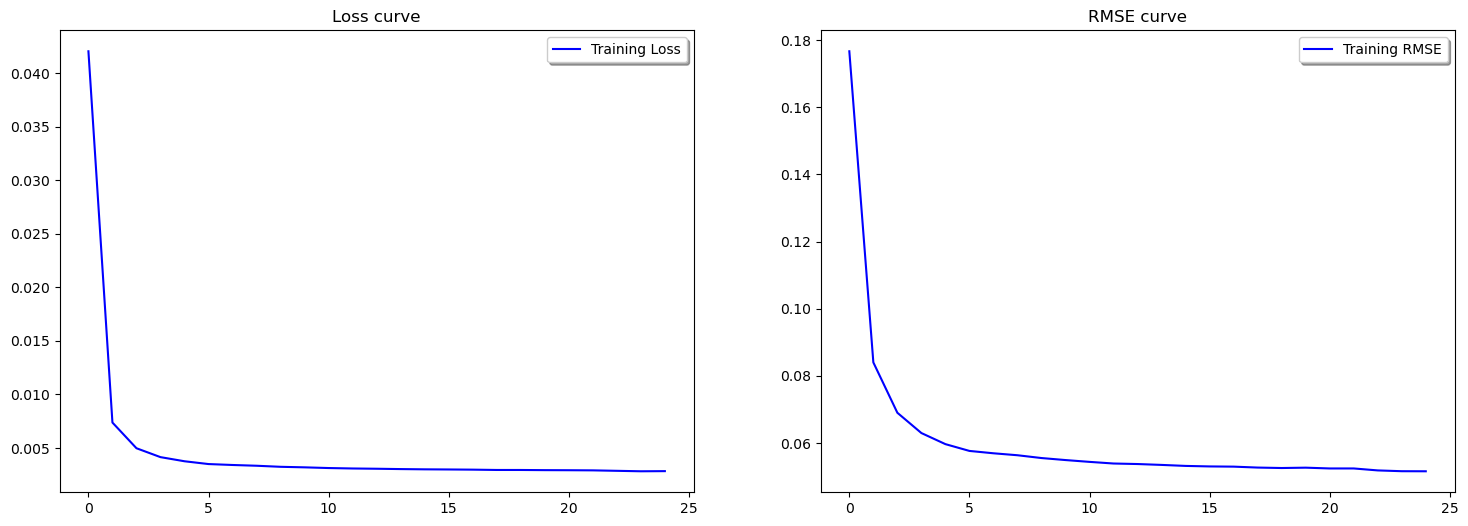

In [26]:
test_df = df_NASDAQ

loss = custom_loss
rnn_type='SimpleRNN'
target = "pct_close"
num_layers = 2 
activation_function = "tanh"
optimizer = 'rmsprop'
dropout = 0.1
units = 50
epoch = 25
batch_size = 32

look_back = 30
test_coef = 21
ticker = "NASDAQ Composite"


regressor, X_test, scaler_y, y_test_NASDAQ_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                              target = target,
                                                                                              rnn_type = rnn_type,  
                                                                                              look_back = look_back,
                                                                                              test_coef = test_coef,
                                                                                              dropout = dropout,
                                                                                              epochs = epoch,
                                                                                              num_layers=num_layers,
                                                                                              activation_function=activation_function,
                                                                                              loss = loss,
                                                                                              batch_size = batch_size)
predicted_price_NASDAQ_SimpleRNN_Profit_CustomLoss = regressor.predict(X_test, verbose = 0)
predicted_price_NASDAQ_SimpleRNN_Profit_CustomLoss = scaler_y.inverse_transform(predicted_price_NASDAQ_SimpleRNN_Profit_CustomLoss).ravel()

SimpleRNN_Profit_CustomLoss_NASDAQ = regression_results(epochs = epoch,
                                      elapsed_time = elapsed_time,
                                      train_loss = history.history['loss'],
                                      train_rmse = history.history['Keras_RMSE'],
                                      y_test = y_test_NASDAQ_Raw,
                                      predicted_price = predicted_price_NASDAQ_SimpleRNN_Profit_CustomLoss)

display(SimpleRNN_Profit_CustomLoss_NASDAQ.style.hide())

plot_loss_regression(train_loss = history.history['loss'],
                     train_rmse = history.history['Keras_RMSE'])

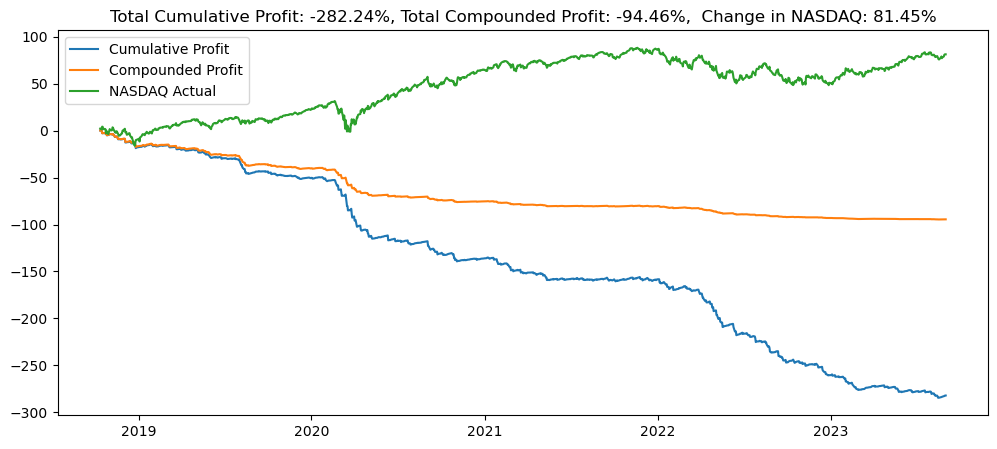

In [27]:
total, profitDf = profit(df_NASDAQ, predicted_price_NASDAQ_SimpleRNN_Profit_CustomLoss)
profitDf["NASDAQ Actual"] = np.cumsum(y_test_NASDAQ_Raw[-1230:])

profitDf[['Cumulative Profit', 'Compounded Profit', "NASDAQ Actual"]].plot(figsize = (12,5))
plt.title(f'Total Cumulative Profit: {round(profitDf["Cumulative Profit"][-1], 2)}%, Total Compounded Profit: {round(profitDf["Compounded Profit"][-1], 2)}%,  Change in NASDAQ: {round(profitDf["NASDAQ Actual"][-1], 2)}%')
plt.show()

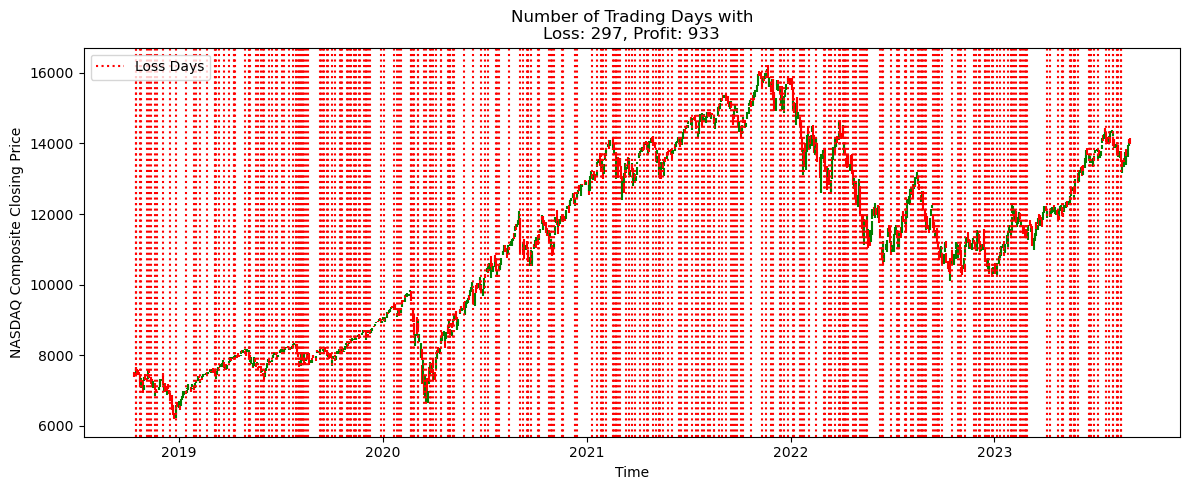

In [30]:
loss_arr = loss(df_NASDAQ, predicted_price_NASDAQ_SimpleRNN_Profit_CustomLoss[-1230:])

line = ["SimpleRNN With Custom Loss Function"]
line.append(round(profitDf["Cumulative Profit"][-1], 2))
line.append(round(profitDf["Compounded Profit"][-1], 2))
line.append(sum(loss_arr))
line.append(len(loss_arr) - sum(loss_arr))
info.append(line)


plot_loss_days(df_NASDAQ, loss_arr, "NASDAQ Composite")

### LSTM

epochs,epochs completed,elapsed time,test RMSE,min train loss,min train RMSE
25,25,104.430000,1.640000,0.002931,0.052430


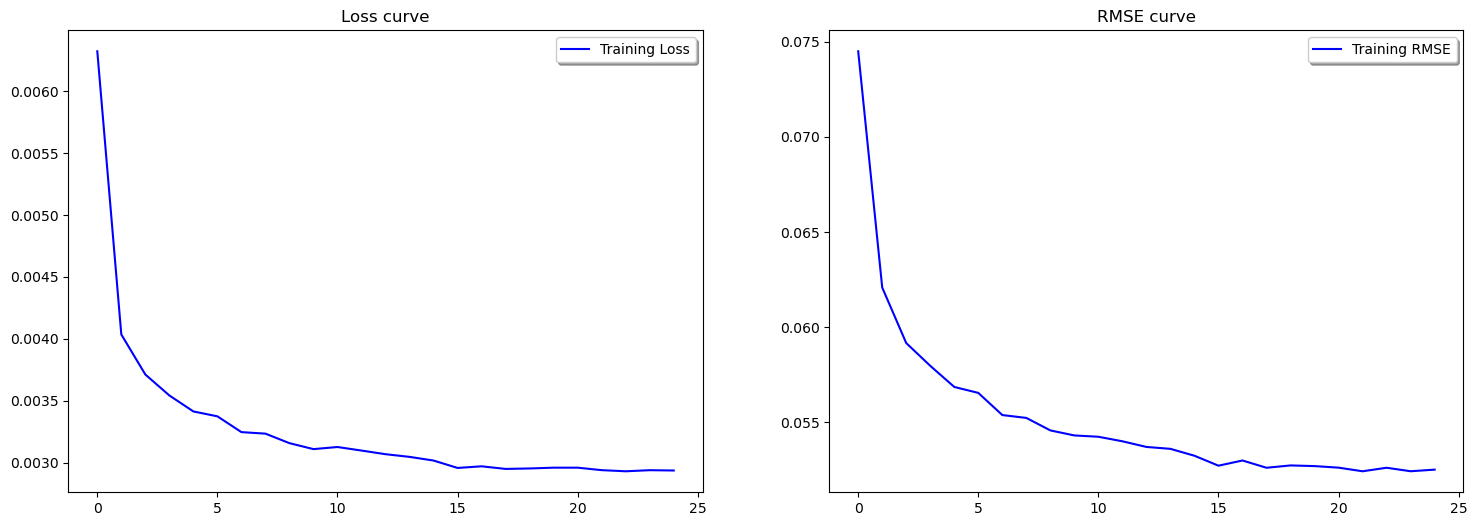

In [31]:
rnn_type='LSTM'
num_layers = 2 
activation_function = "tanh"
optimizer = 'rmsprop'
dropout = 0.1
units = 50
epoch = 25
batch_size = 32

look_back = 30
test_coef = 21
ticker = "NASDAQ Composite"


regressor, X_test, scaler_y, y_test_NASDAQ_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                              target = target,
                                                                                              rnn_type = rnn_type,  
                                                                                              look_back = look_back,
                                                                                              test_coef = test_coef,
                                                                                              dropout = dropout,
                                                                                              epochs = epoch,
                                                                                              num_layers=num_layers,
                                                                                              activation_function=activation_function,
                                                                                              loss = loss,
                                                                                              batch_size = batch_size)
predicted_price_NASDAQ_LSTM_Profit_CustomLoss = regressor.predict(X_test, verbose = 0)
predicted_price_NASDAQ_LSTM_Profit_CustomLoss = scaler_y.inverse_transform(predicted_price_NASDAQ_LSTM_Profit_CustomLoss).ravel()

LSTM_Profit_CustomLoss_NASDAQ = regression_results(epochs = epoch,
                                      elapsed_time = elapsed_time,
                                      train_loss = history.history['loss'],
                                      train_rmse = history.history['Keras_RMSE'],
                                      y_test = y_test_NASDAQ_Raw,
                                      predicted_price = predicted_price_NASDAQ_LSTM_Profit_CustomLoss)

display(LSTM_Profit_CustomLoss_NASDAQ.style.hide())

plot_loss_regression(train_loss = history.history['loss'],
                     train_rmse = history.history['Keras_RMSE'])

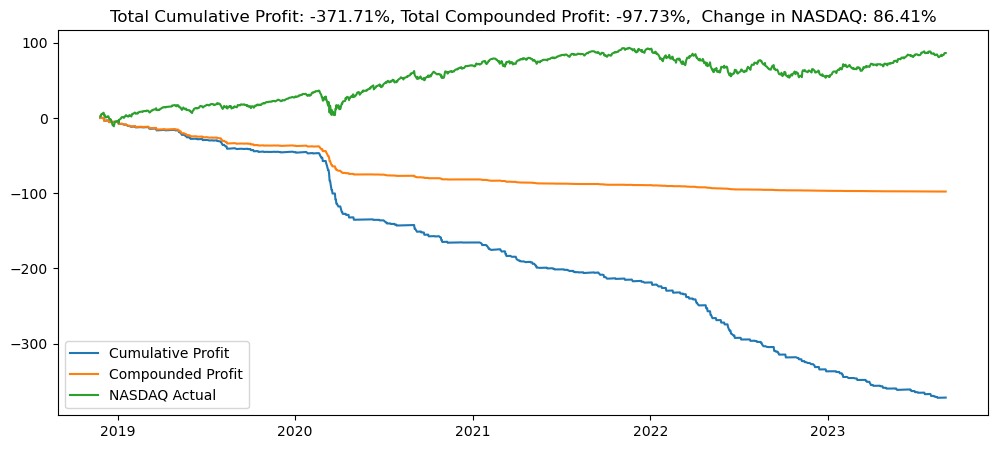

In [32]:
total, profitDf = profit(df_NASDAQ, predicted_price_NASDAQ_LSTM_Profit_CustomLoss[-1200:])
profitDf["NASDAQ Actual"] = np.cumsum(y_test_NASDAQ_Raw[-1200:])

profitDf[['Cumulative Profit', 'Compounded Profit', "NASDAQ Actual"]].plot(figsize = (12,5))
plt.title(f'Total Cumulative Profit: {round(profitDf["Cumulative Profit"][-1], 2)}%, Total Compounded Profit: {round(profitDf["Compounded Profit"][-1], 2)}%,  Change in NASDAQ: {round(profitDf["NASDAQ Actual"][-1], 2)}%')
plt.show()

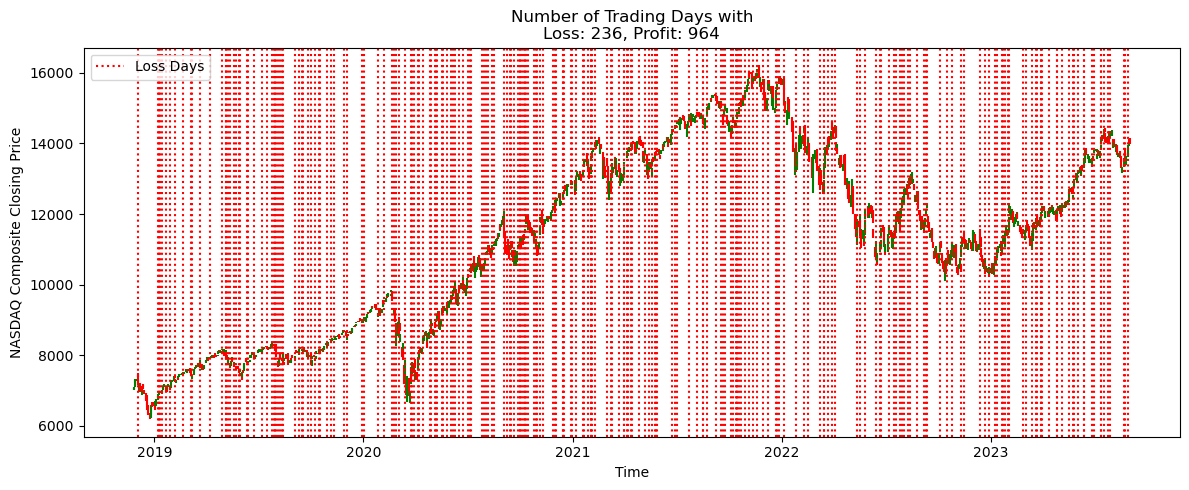

In [33]:
loss_arr = loss(df_NASDAQ, predicted_price_NASDAQ_LSTM_Profit[-1200:])

line = ["LSTM With Custom Loss Function"]
line.append(round(profitDf["Cumulative Profit"][-1], 2))
line.append(round(profitDf["Compounded Profit"][-1], 2))
line.append(sum(loss_arr))
line.append(len(loss_arr) - sum(loss_arr))
info.append(line)

plot_loss_days(df_NASDAQ, loss_arr, "NASDAQ Composite")

### GRU

epochs,epochs completed,elapsed time,test RMSE,min train loss,min train RMSE
25,25,84.100000,1.640000,0.002952,0.052376


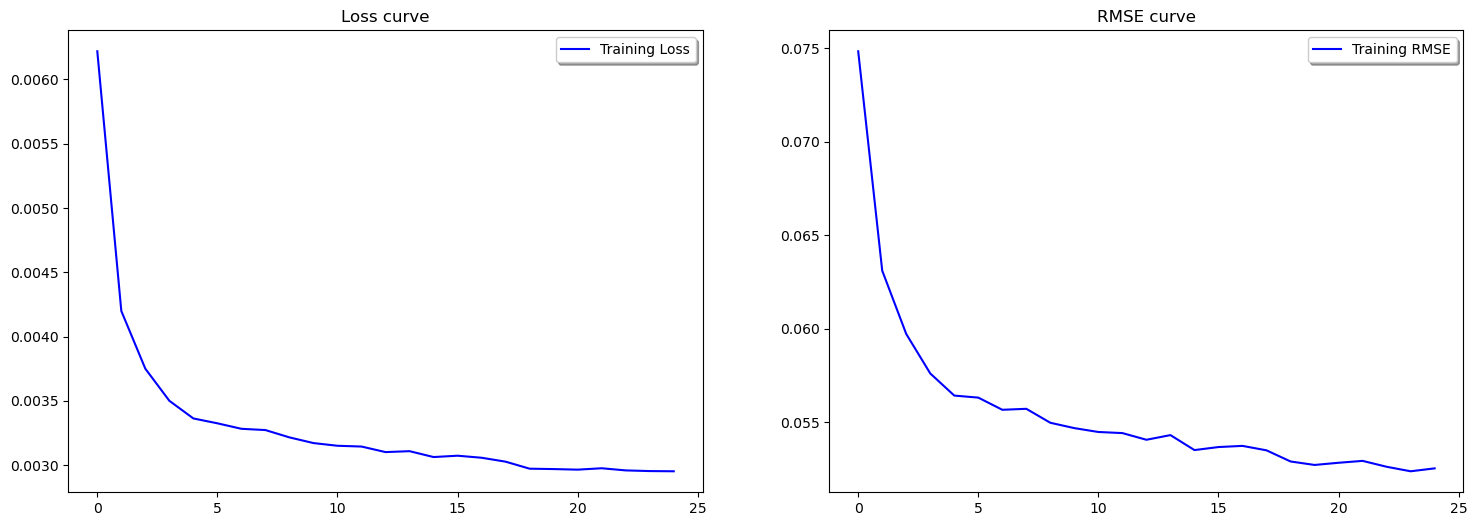

In [34]:
rnn_type='GRU'
num_layers = 2 
activation_function = "tanh"
optimizer = 'rmsprop'
dropout = 0.1
units = 50
epoch = 25
batch_size = 32

look_back = 30
test_coef = 21
ticker = "NASDAQ Composite"

regressor, X_test, scaler_y, y_test_NASDAQ_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                              target = target,
                                                                                              rnn_type = rnn_type,  
                                                                                              look_back = look_back,
                                                                                              test_coef = test_coef,
                                                                                              dropout = dropout,
                                                                                              epochs = epoch,
                                                                                              num_layers=num_layers,
                                                                                              activation_function=activation_function,
                                                                                              loss = loss,
                                                                                              batch_size = batch_size)
predicted_price_NASDAQ_GRU_Profit_CustomLoss = regressor.predict(X_test, verbose = 0)
predicted_price_NASDAQ_GRU_Profit_CustomLoss = scaler_y.inverse_transform(predicted_price_NASDAQ_GRU_Profit_CustomLoss).ravel()

GRU_Profit_CustomLoss_NASDAQ = regression_results(epochs = epoch,
                                      elapsed_time = elapsed_time,
                                      train_loss = history.history['loss'],
                                      train_rmse = history.history['Keras_RMSE'],
                                      y_test = y_test_NASDAQ_Raw,
                                      predicted_price = predicted_price_NASDAQ_GRU_Profit_CustomLoss)

display(GRU_Profit_CustomLoss_NASDAQ.style.hide())

plot_loss_regression(train_loss = history.history['loss'],
                     train_rmse = history.history['Keras_RMSE'])

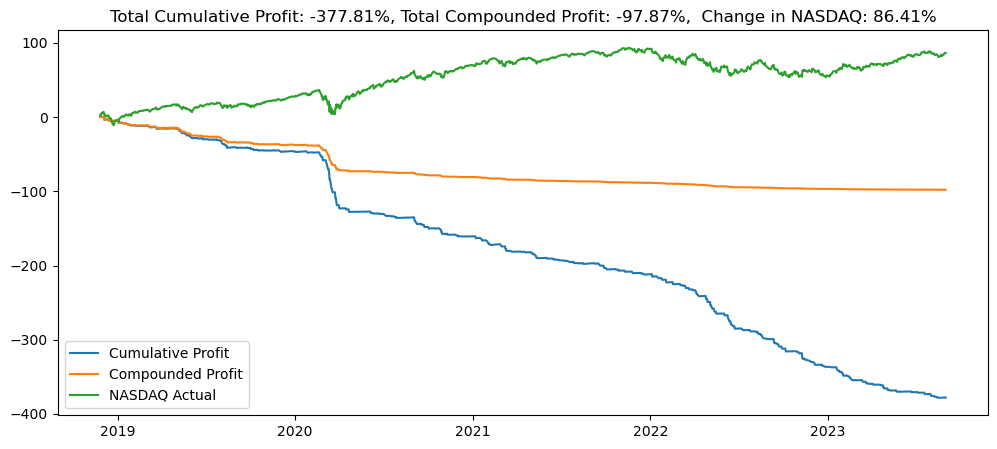

In [35]:
total, profitDf = profit(df_NASDAQ, predicted_price_NASDAQ_GRU_Profit_CustomLoss[-1200:])
profitDf["NASDAQ Actual"] = np.cumsum(y_test_NASDAQ_Raw[-1200:])

profitDf[['Cumulative Profit', 'Compounded Profit', "NASDAQ Actual"]].plot(figsize = (12,5))
plt.title(f'Total Cumulative Profit: {round(profitDf["Cumulative Profit"][-1], 2)}%, Total Compounded Profit: {round(profitDf["Compounded Profit"][-1], 2)}%,  Change in NASDAQ: {round(profitDf["NASDAQ Actual"][-1], 2)}%')
plt.show()

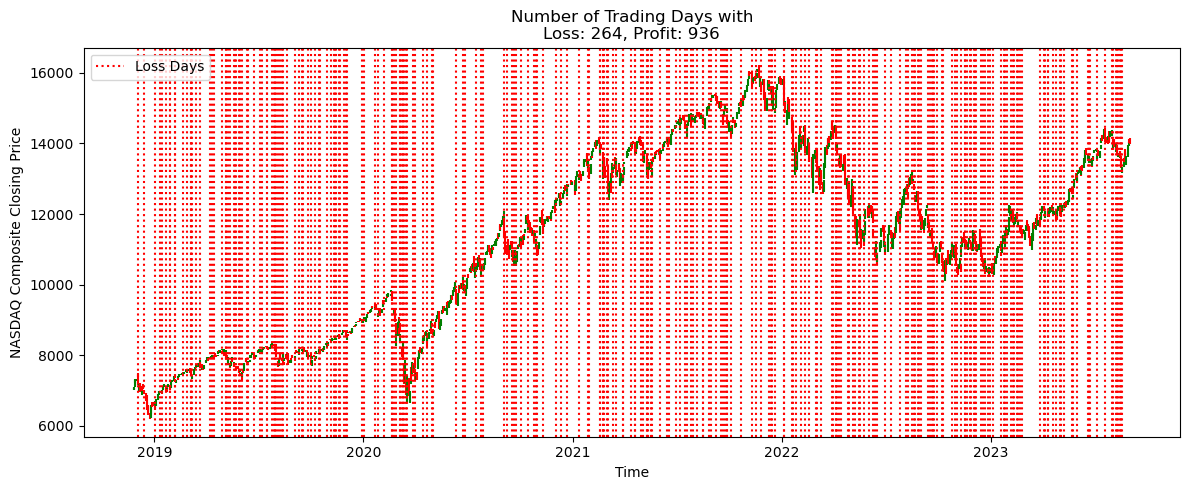

In [36]:
loss_arr = loss(df_NASDAQ, predicted_price_NASDAQ_GRU_Profit[-1200:])

line = ["GRU With Custom Loss Function"]
line.append(round(profitDf["Cumulative Profit"][-1], 2))
line.append(round(profitDf["Compounded Profit"][-1], 2))
line.append(sum(loss_arr))
line.append(len(loss_arr) - sum(loss_arr))
info.append(line)


plot_loss_days(df_NASDAQ, loss_arr, "NASDAQ Composite")

## Adding Technical Indicators and Indices

In [37]:
indices = [
    "BTC-USD",
    "^VIX",    # CBOE Volatility Index (VIX)
    "^DJI",    # Dow Jones Industrial Average
    "^GSPC",   # S&P 500 Index
    "^FTSE",   # FTSE 100 Index (UK)
    "^GDAXI",  # DAX 30 Index (Germany)
    "^FCHI",   # CAC 40 Index (France)
    "^N225",   # Nikkei 225 Index (Japan)
    "^HSI",    # Hang Seng Index (Hong Kong)
    "^AXJO",   # S&P/ASX 200 Index (Australia)
    "^KS11",   # KOSPI Composite Index (South Korea)
    "^BSESN",  # BSE SENSEX (India)
    "^BVSP",   # Bovespa Index (Brazil)
    "GC=F",    # Gold Futures
    "SI=F",    # Silver Futures
    "CL=F",    # Crude Oil WTI Futures
    "NG=F",    # Natural Gas Futures
    "ZC=F",    # Corn Futures
    "ZW=F",    # Wheat Futures
]

columns_with_outliers    = ['Volume', 'SMA_50', 'SMA_100', 'SMA_200', 'Momentum', 'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'TR', 'ATR', 'Middle_Band', 'Upper_Band', 'Lower_Band', 'vol_pct_change']
columns_to_log_transform = ['Volume', 'Momentum', 'TR', 'ATR', 'OBV', 'Upper_Band', 'Lower_Band', 'vol_pct_change']

In [38]:
nasdaq = yf.Ticker("^IXIC")
df_NASDAQ = nasdaq.history(period="max")
df_NASDAQ.index = df_NASDAQ.index.date

df_indices = get_indices_pct_change(indices)
final_df = pd.concat([df_indices, df_NASDAQ], axis = 1)
final_df.fillna(method = "ffill", inplace=True)
final_df = add_technical_indicators(final_df)

for idx in indices:
    final_df[idx] = final_df[idx].pct_change()

final_df = final_df[final_df.Volume != 0]
final_df.dropna(inplace=True)
final_df = final_df.iloc[1:]

min_momentum = final_df.Momentum.min()
min_OBV = final_df.OBV.min()
min_Upper_Band = final_df.Upper_Band.min()
min_Lower_Band = final_df.Lower_Band.min()
min_vol_pct_change = final_df.vol_pct_change.min()

final_df.loc[:, 'Momentum']       = final_df['Momentum'] - min_momentum + 1
final_df.loc[:, 'OBV']            = final_df['OBV'] - min_OBV + 1
final_df.loc[:, 'Upper_Band']     = final_df['Upper_Band'] - min_Upper_Band + 1
final_df.loc[:, 'Lower_Band']     = final_df['Lower_Band'] - min_Lower_Band + 1
final_df.loc[:, 'vol_pct_change'] = final_df['vol_pct_change'] - min_vol_pct_change + 1

X = final_df.drop("pct_close", axis = 1)
y = final_df.pct_close

pipeline = pip.Pipeline([
        ('log_transform', LogTransformer(columns=columns_to_log_transform)),
        ('winsorizer', fout.Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=columns_with_outliers)),
        ('scaler', pre.MinMaxScaler()),
        ('drop_duplicate', fsel.DropDuplicateFeatures()),
        ('drop_correlated', fsel.DropCorrelatedFeatures()),
        ('drop_constant', fsel.DropConstantFeatures(tol=0.998))
        ])

final_df_transformed = pipeline.fit_transform(X)

cols = []

for idx in pd.to_numeric(pd.Series(final_df_transformed.columns).str.replace("x", "")):
    cols.append(final_df.columns[idx])
    
final_df_transformed.columns = cols
final_df_transformed.index = final_df.index
final_df_transformed["pct_close"] = final_df["pct_close"]
final_df_transformed.head()

,^GSPC,^N225,^FTSE,^HSI,^VIX,^AXJO,^BVSP,^KS11,^BSESN,ZC=F,...,dayofweek_cos,weekofyear_sin,weekofyear_cos,SMA_100,SMA_200,RSI,Signal_Line,Middle_Band,Upper_Band,Lower_Band
2014-09-19,0.56,0.60,0.56,0.45,0.19,0.60,0.48,0.51,0.59,0.61,...,0.01,0.40,0.55,0.61,0.48,0.57,0.27,0.78,0.32,1.00
2014-09-20,0.56,0.50,0.55,0.41,0.18,0.58,0.52,0.49,0.59,0.68,...,0.01,0.40,0.54,0.60,0.45,0.52,0.27,0.78,0.32,0.50
2014-09-21,0.56,0.50,0.55,0.41,0.18,0.58,0.52,0.49,0.59,0.68,...,0.01,0.40,0.54,0.60,0.49,0.50,0.27,0.78,0.32,0.50
2014-09-22,0.52,0.45,0.50,0.32,0.28,0.50,0.46,0.45,0.61,0.67,...,0.00,0.46,0.47,0.56,0.42,0.38,0.36,0.65,0.22,0.00
2014-09-23,0.53,0.50,0.47,0.38,0.25,0.64,0.50,0.46,0.52,0.63,...,0.00,0.46,0.44,0.54,0.36,0.37,0.15,0.60,0.20,0.44


In [39]:
def custom_loss(y_true, y_pred):
    signs_match = tf.math.sign(y_true) == tf.math.sign(y_pred)
    error = tf.where(signs_match, 0.0, tf.square(y_true - y_pred))
    loss = tf.reduce_mean(error)
    return loss

## SimpleRNN with Technical Indicators and Indices

epochs,epochs completed,elapsed time,test RMSE,min train loss,min train RMSE
25,25,12.550000,1.410000,0.003167,0.054953


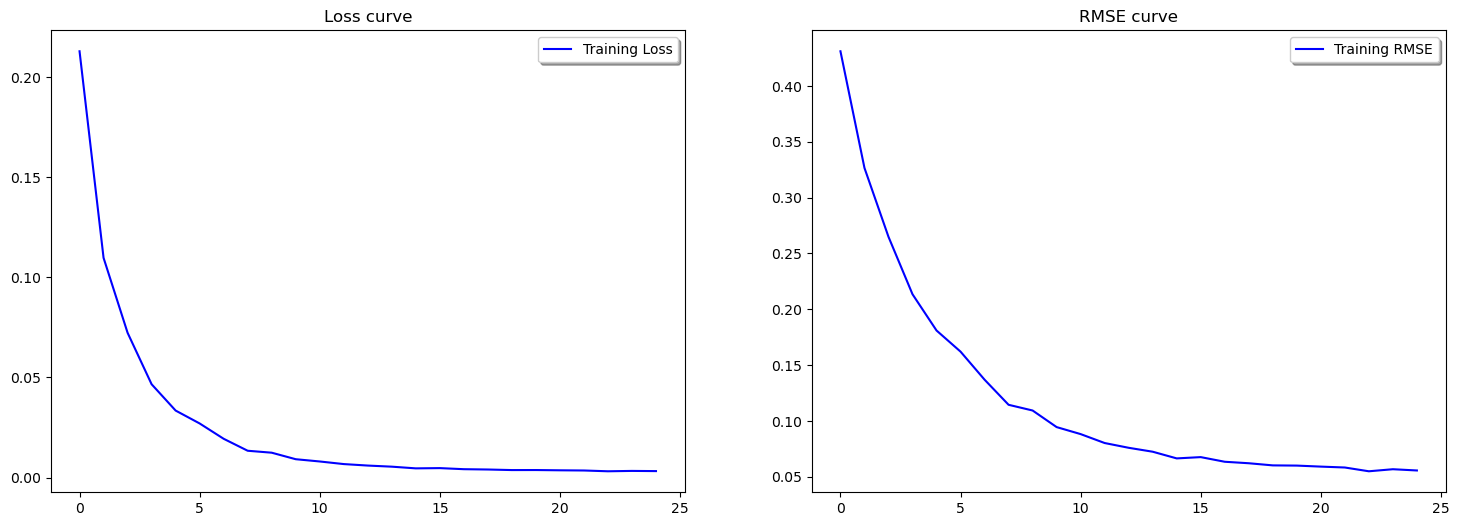

In [40]:
test_df = final_df_transformed

rnn_type='SimpleRNN'
target = "pct_close"
num_layers = 2 
activation_function = "tanh"
optimizer = 'rmsprop'
dropout = 0.1
units = 50
epoch = 25
batch_size = 32

look_back = 30
test_coef = 21
ticker = "NASDAQ Composite"


regressor, X_test, scaler_y, y_test_NASDAQ_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                              target = target,
                                                                                              rnn_type = rnn_type,  
                                                                                              look_back = look_back,
                                                                                              test_coef = test_coef,
                                                                                              dropout = dropout,
                                                                                              epochs = epoch,
                                                                                              num_layers=num_layers,
                                                                                              activation_function=activation_function,
                                                                                              loss = loss,
                                                                                              batch_size = batch_size)
predicted_price_NASDAQ_SimpleRNN_Technical_Transformed = regressor.predict(X_test, verbose = 0)
predicted_price_NASDAQ_SimpleRNN_Technical_Transformed = scaler_y.inverse_transform(predicted_price_NASDAQ_SimpleRNN_Technical_Transformed).ravel()

SimpleRNN_Technical_Transformed_NASDAQ = regression_results(epochs = epoch,
                                      elapsed_time = elapsed_time,
                                      train_loss = history.history['loss'],
                                      train_rmse = history.history['Keras_RMSE'],
                                      y_test = y_test_NASDAQ_Raw,
                                      predicted_price = predicted_price_NASDAQ_SimpleRNN_Technical_Transformed)

display(SimpleRNN_Technical_Transformed_NASDAQ.style.hide())

plot_loss_regression(train_loss = history.history['loss'],
                     train_rmse = history.history['Keras_RMSE'])

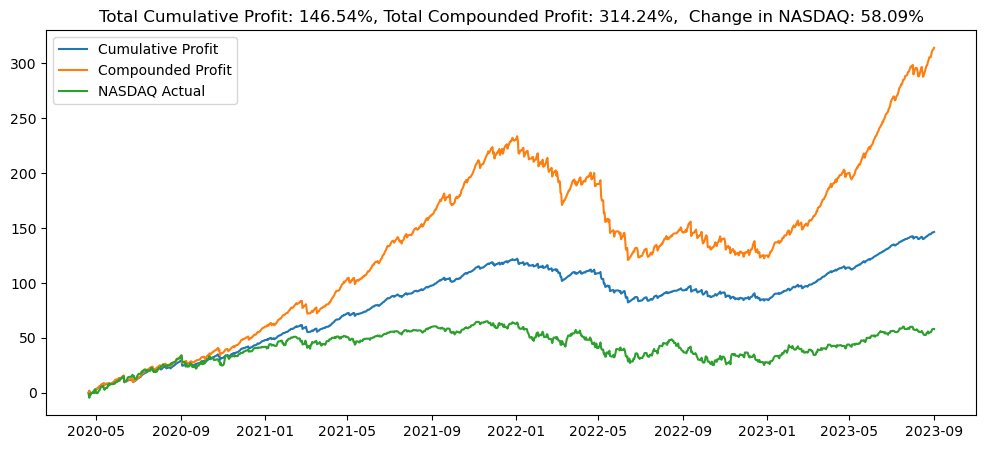

In [41]:
total, profitDf = profit(final_df_transformed, predicted_price_NASDAQ_SimpleRNN_Technical_Transformed)
profitDf["NASDAQ Actual"] = np.cumsum(y_test_NASDAQ_Raw[-1230:])

profitDf[['Cumulative Profit', 'Compounded Profit', "NASDAQ Actual"]].plot(figsize = (12,5))
plt.title(f'Total Cumulative Profit: {round(profitDf["Cumulative Profit"][-1], 2)}%, Total Compounded Profit: {round(profitDf["Compounded Profit"][-1], 2)}%,  Change in NASDAQ: {round(profitDf["NASDAQ Actual"][-1], 2)}%')
plt.show()

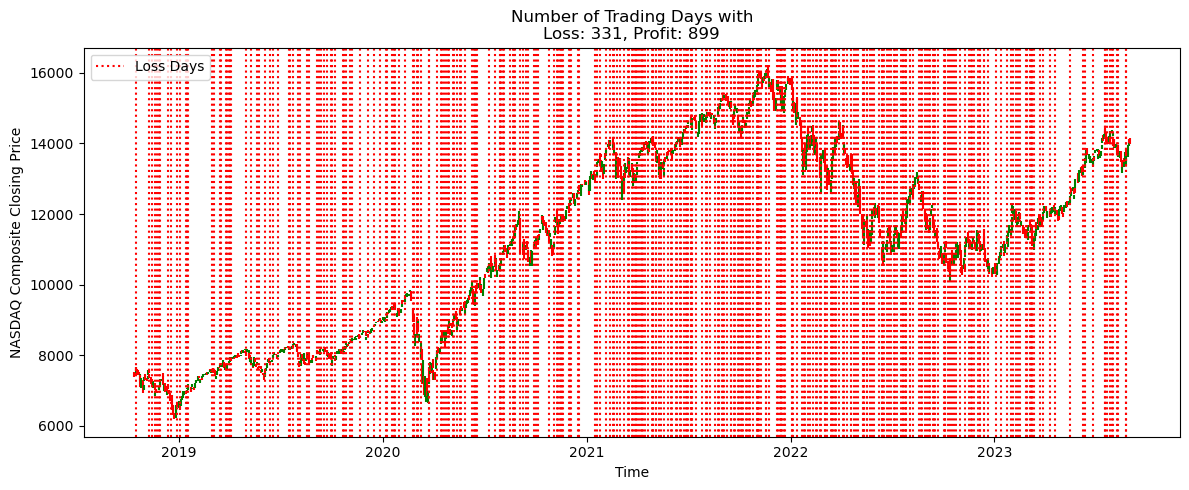

In [42]:
loss_arr = loss(final_df_transformed, predicted_price_NASDAQ_SimpleRNN_Technical_Transformed)

line = ["SimpleRNN With Custom Loss Function, Technical Indicators and Indices"]
line.append(round(profitDf["Cumulative Profit"][-1], 2))
line.append(round(profitDf["Compounded Profit"][-1], 2))
line.append(sum(loss_arr))
line.append(len(loss_arr) - sum(loss_arr))
info.append(line)


plot_loss_days(df_NASDAQ, loss_arr, "NASDAQ Composite")

## LSTM with Technical Indicators and Indices

epochs,epochs completed,elapsed time,test RMSE,min train loss,min train RMSE
25,25,29.530000,1.330000,0.002829,0.050892


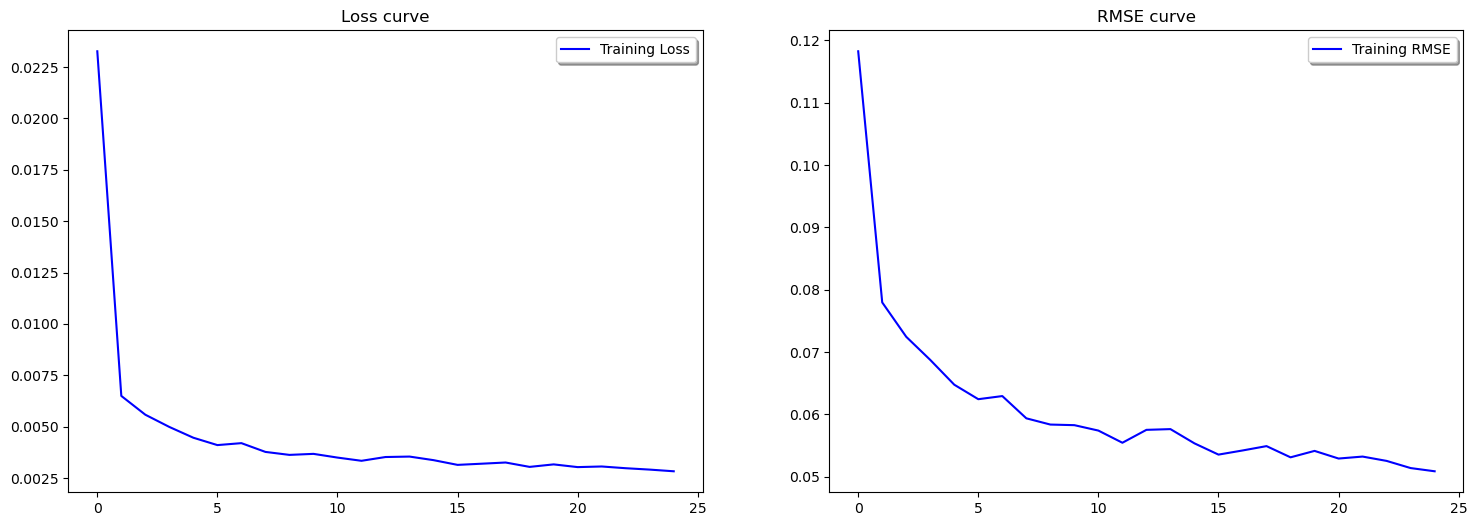

In [43]:
rnn_type='LSTM'
target = "pct_close"
num_layers = 2 
activation_function = "tanh"
optimizer = 'rmsprop'
dropout = 0.1
units = 50
epoch = 25
batch_size = 32

look_back = 30
test_coef = 21
ticker = "NASDAQ Composite"


regressor, X_test, scaler_y, y_test_NASDAQ_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                              target = target,
                                                                                              rnn_type = rnn_type,  
                                                                                              look_back = look_back,
                                                                                              test_coef = test_coef,
                                                                                              dropout = dropout,
                                                                                              epochs = epoch,
                                                                                              num_layers=num_layers,
                                                                                              loss = loss,
                                                                                              activation_function=activation_function,
                                                                                              batch_size = batch_size)
predicted_price_NASDAQ_LSTM_Technical_Transformed = regressor.predict(X_test, verbose = 0)
predicted_price_NASDAQ_LSTM_Technical_Transformed = scaler_y.inverse_transform(predicted_price_NASDAQ_LSTM_Technical_Transformed).ravel()

LSTM_Technical_Transformed_NASDAQ = regression_results(epochs = epoch,
                                      elapsed_time = elapsed_time,
                                      train_loss = history.history['loss'],
                                      train_rmse = history.history['Keras_RMSE'],
                                      y_test = y_test_NASDAQ_Raw,
                                      predicted_price = predicted_price_NASDAQ_LSTM_Technical_Transformed)

display(LSTM_Technical_Transformed_NASDAQ.style.hide())

plot_loss_regression(train_loss = history.history['loss'],
                     train_rmse = history.history['Keras_RMSE'])

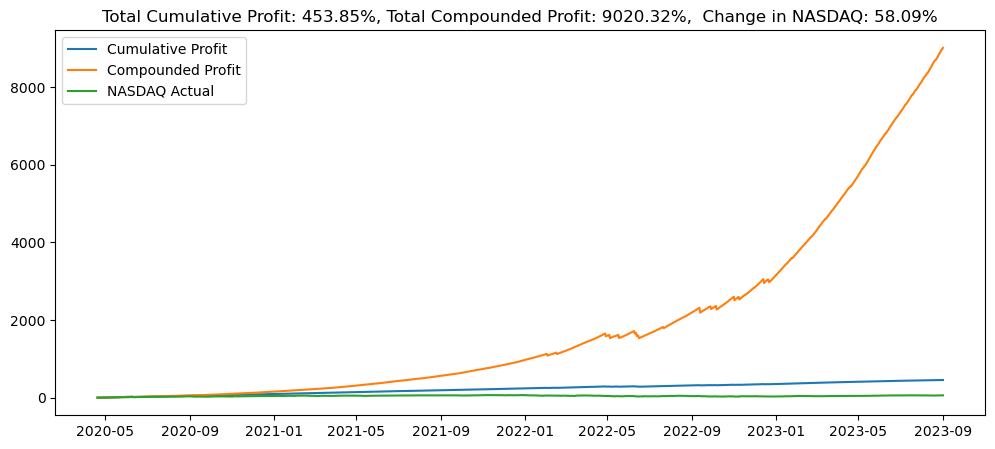

In [44]:
total, profitDf = profit(final_df_transformed, predicted_price_NASDAQ_LSTM_Technical_Transformed)
profitDf["NASDAQ Actual"] = np.cumsum(y_test_NASDAQ_Raw[-1230:])

profitDf[['Cumulative Profit', 'Compounded Profit', "NASDAQ Actual"]].plot(figsize = (12,5))
plt.title(f'Total Cumulative Profit: {round(profitDf["Cumulative Profit"][-1], 2)}%, Total Compounded Profit: {round(profitDf["Compounded Profit"][-1], 2)}%,  Change in NASDAQ: {round(profitDf["NASDAQ Actual"][-1], 2)}%')
plt.show()

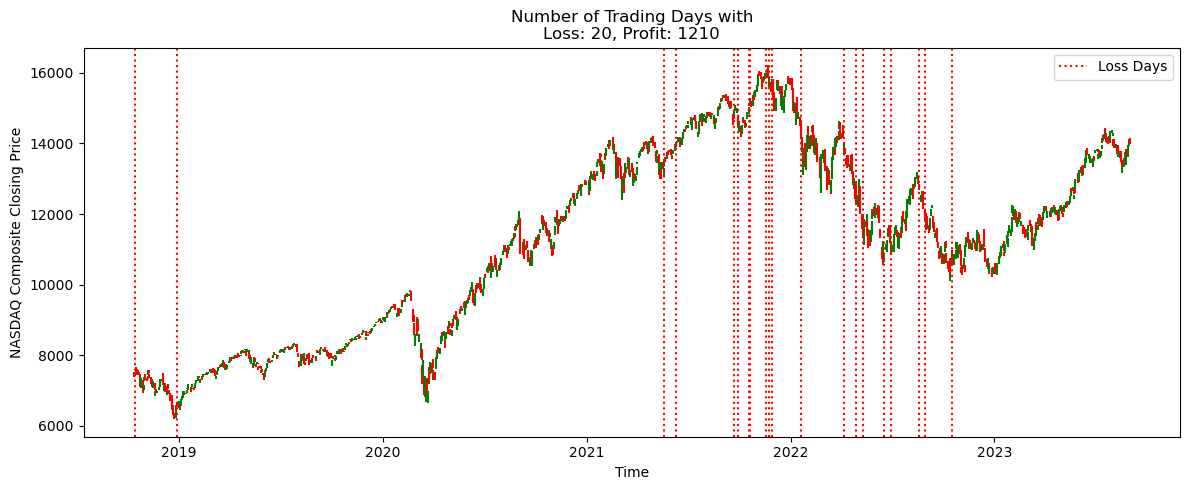

In [45]:
loss_arr = loss(final_df_transformed, predicted_price_NASDAQ_LSTM_Technical_Transformed)

line = ["LSTM With Custom Loss Function, Technical Indicators and Indices"]
line.append(round(profitDf["Cumulative Profit"][-1], 2))
line.append(round(profitDf["Compounded Profit"][-1], 2))
line.append(sum(loss_arr))
line.append(len(loss_arr) - sum(loss_arr))
info.append(line)

plot_loss_days(df_NASDAQ, loss_arr, "NASDAQ Composite")

## GRU with Technical Indicators and Indices

epochs,epochs completed,elapsed time,test RMSE,min train loss,min train RMSE
25,25,29.850000,1.290000,0.002859,0.051351


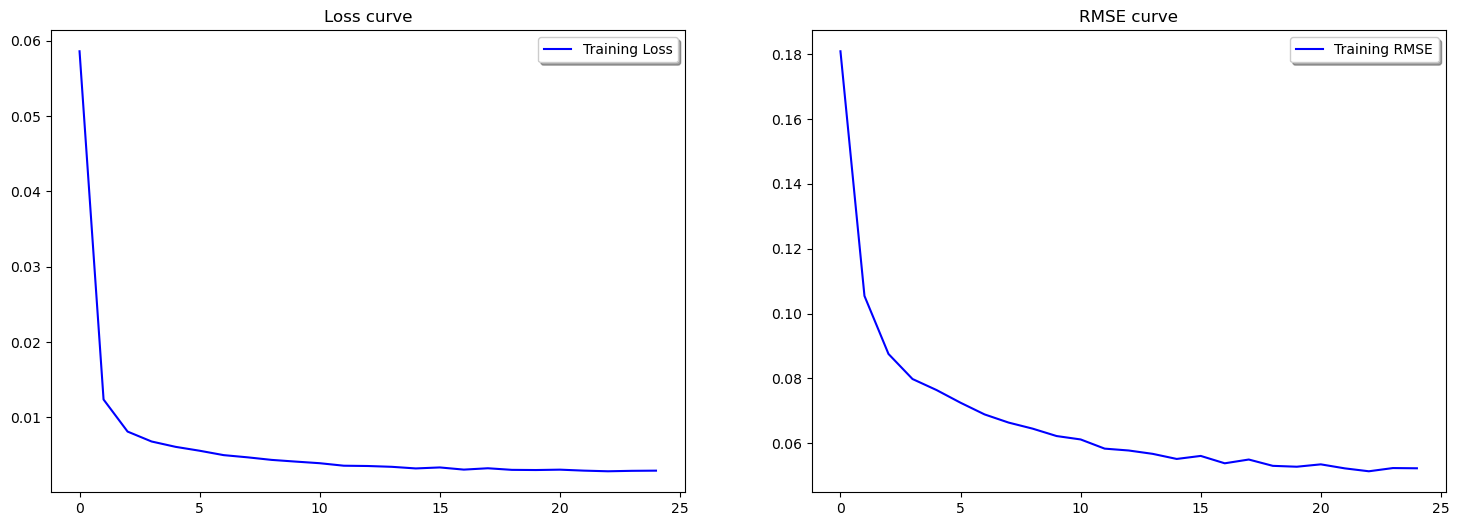

In [46]:
rnn_type='GRU'
target = "pct_close"
num_layers = 2 
activation_function = "tanh"
optimizer = 'rmsprop'
dropout = 0.1
units = 50
epoch = 25
batch_size = 32

look_back = 30
test_coef = 21
ticker = "NASDAQ Composite"


regressor, X_test, scaler_y, y_test_NASDAQ_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                              target = target,
                                                                                              rnn_type = rnn_type,  
                                                                                              look_back = look_back,
                                                                                              test_coef = test_coef,
                                                                                              dropout = dropout,
                                                                                              epochs = epoch,
                                                                                              num_layers=num_layers,
                                                                                              activation_function=activation_function,
                                                                                              loss = loss,
                                                                                              batch_size = batch_size)
predicted_price_NASDAQ_GRU_Technical_Transformed = regressor.predict(X_test, verbose = 0)
predicted_price_NASDAQ_GRU_Technical_Transformed = scaler_y.inverse_transform(predicted_price_NASDAQ_GRU_Technical_Transformed).ravel()

GRU_Technical_Transformed_NASDAQ = regression_results(epochs = epoch,
                                      elapsed_time = elapsed_time,
                                      train_loss = history.history['loss'],
                                      train_rmse = history.history['Keras_RMSE'],
                                      y_test = y_test_NASDAQ_Raw,
                                      predicted_price = predicted_price_NASDAQ_GRU_Technical_Transformed)

display(GRU_Technical_Transformed_NASDAQ.style.hide())

plot_loss_regression(train_loss = history.history['loss'],
                     train_rmse = history.history['Keras_RMSE'])

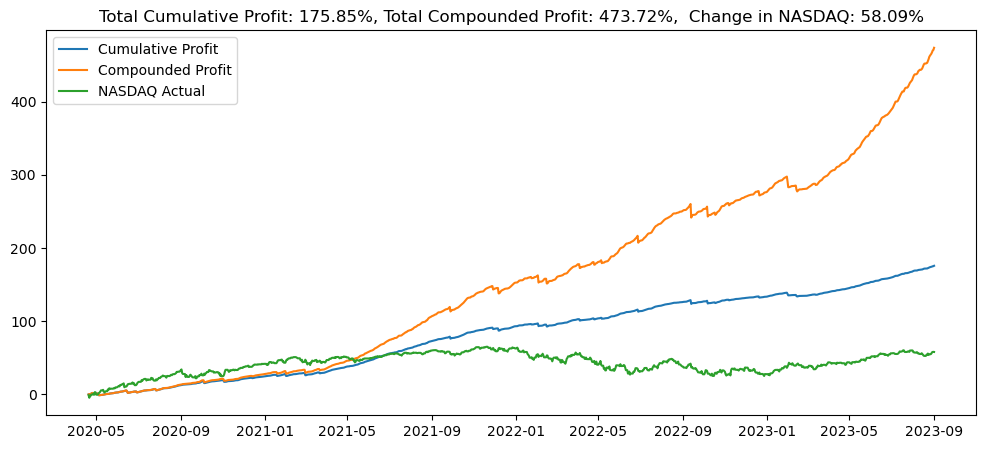

In [47]:
total, profitDf = profit(final_df_transformed, predicted_price_NASDAQ_GRU_Technical_Transformed)
profitDf["NASDAQ Actual"] = np.cumsum(y_test_NASDAQ_Raw[-1230:])

profitDf[['Cumulative Profit', 'Compounded Profit', "NASDAQ Actual"]].plot(figsize = (12,5))
plt.title(f'Total Cumulative Profit: {round(profitDf["Cumulative Profit"][-1], 2)}%, Total Compounded Profit: {round(profitDf["Compounded Profit"][-1], 2)}%,  Change in NASDAQ: {round(profitDf["NASDAQ Actual"][-1], 2)}%')
plt.show()

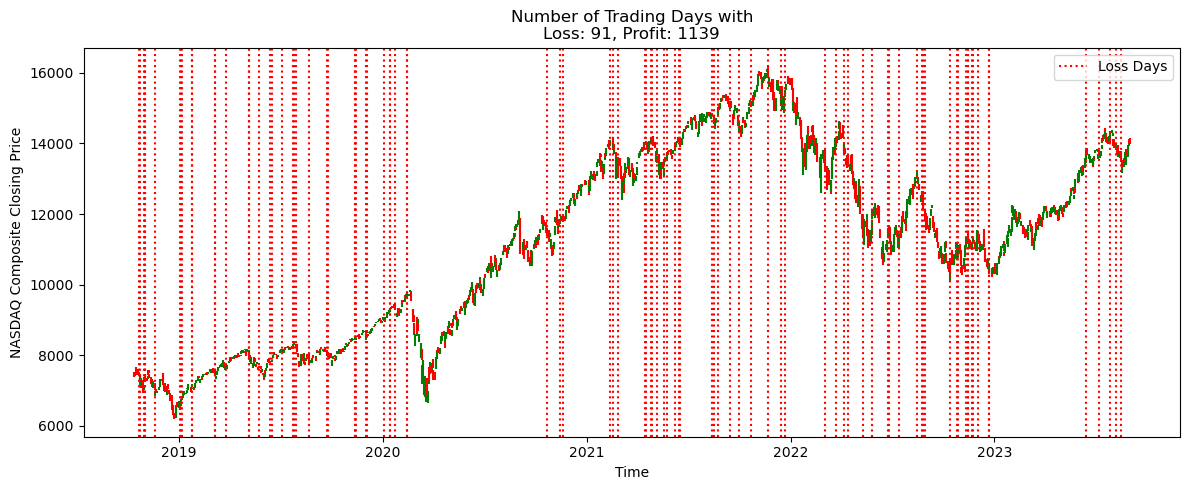

In [48]:
loss_arr = loss(final_df_transformed, predicted_price_NASDAQ_GRU_Technical_Transformed)

line = ["GRU With Custom Loss Function, Technical Indicators and Indices"]
line.append(round(profitDf["Cumulative Profit"][-1], 2))
line.append(round(profitDf["Compounded Profit"][-1], 2))
line.append(sum(loss_arr))
line.append(len(loss_arr) - sum(loss_arr))
info.append(line)

plot_loss_days(df_NASDAQ, loss_arr, "NASDAQ Composite")

In [49]:
pd.set_option('display.max_colwidth', None)
df_results_final = pd.DataFrame(info, columns=["Explanation", "Cumulative Profit", "Compounded Profit", "Nr of Loss Days", "Nr of Profit Days"])
df_results_final

,Explanation,Cumulative Profit,Compounded Profit,Nr of Loss Days,Nr of Profit Days
0,SimpleRNN Without Custom Loss Function,-236.20,-91.06,238,962
1,LSTM Without Custom Loss Function,-382.08,-97.93,236,964
2,GRU Without Custom Loss Function,-274.42,-93.98,275,955
3,SimpleRNN With Custom Loss Function,-282.24,-94.46,297,933
4,LSTM With Custom Loss Function,-371.71,-97.73,236,964
5,GRU With Custom Loss Function,-377.81,-97.87,264,936
6,"SimpleRNN With Custom Loss Function, Technical Indicators and Indices",146.54,314.24,331,899
7,"LSTM With Custom Loss Function, Technical Indicators and Indices",453.85,9020.32,20,1210
8,"GRU With Custom Loss Function, Technical Indicators and Indices",175.85,473.72,91,1139
